In [5]:
import numpy as np 
from matplotlib import pyplot as plt 
import h5py
import scipy.io
import astropy
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15 as cosmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use('../cooper-paper.mplstyle')

In [7]:
file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_EAZYSED.idl'
#file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/uds/UDS_candidates_all.idl'
#file = '/Users/oc4858/werls/COSMOS_F21.idl'
ez = scipy.io.readsav(file)

In [16]:
# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
wra = float(notes['objra'][idx]); wdec = float(notes['objdec'][idx])
print('working on object',obj_name,'with zguess = ',zguess)

working on object M_W69492 with zguess =  7.4775


In [14]:
file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_trimmed.idl'
pzfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_pz.idl'
ezfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_EAZYSED.idl'
pz = scipy.io.readsav(pzfile)
ez = scipy.io.readsav(ezfile)
idl = scipy.io.readsav(file).cat
# load best fit sed
wvl = ez.lam*u.AA
fnu_mods = ez.model*u.erg/u.s/u.Hz/u.cm**2

/opt/anaconda3/lib/python3.9/site-packages/scipy/io/idl.py:465: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


In [26]:
pz.zgrid

array([1.000e-02, 2.000e-02, 3.000e-02, ..., 1.498e+01, 1.499e+01,
       1.500e+01])

In [28]:
# load catalog ra/dec
catra = idl.ra[0]; catdec = idl.dec[0]
# crossmatch
c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
ind, d2d, d3d = catalog.match_to_catalog_sky(c)
if d2d > 1*u.arcsec:
    print("!! xmatch to source is > 1 arcsec !!")

print('distance to xmatch is ',d2d.to(u.arcsec))

# load fluxes
fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

# find mags
Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
MUV = (Jmag.value)-(cosmo.distmod(zguess).value)+(2.5*np.log10(1+zguess)) # abs UV mag

# load best fit sed
fnu_mod = fnu_mods[ind]

# load zpdf
za = idl.photz[0].za[0][ind]
zarr = pz.zgrid
zpdf = pz.pz[ind]

distance to xmatch is  [0.0144arcsec]


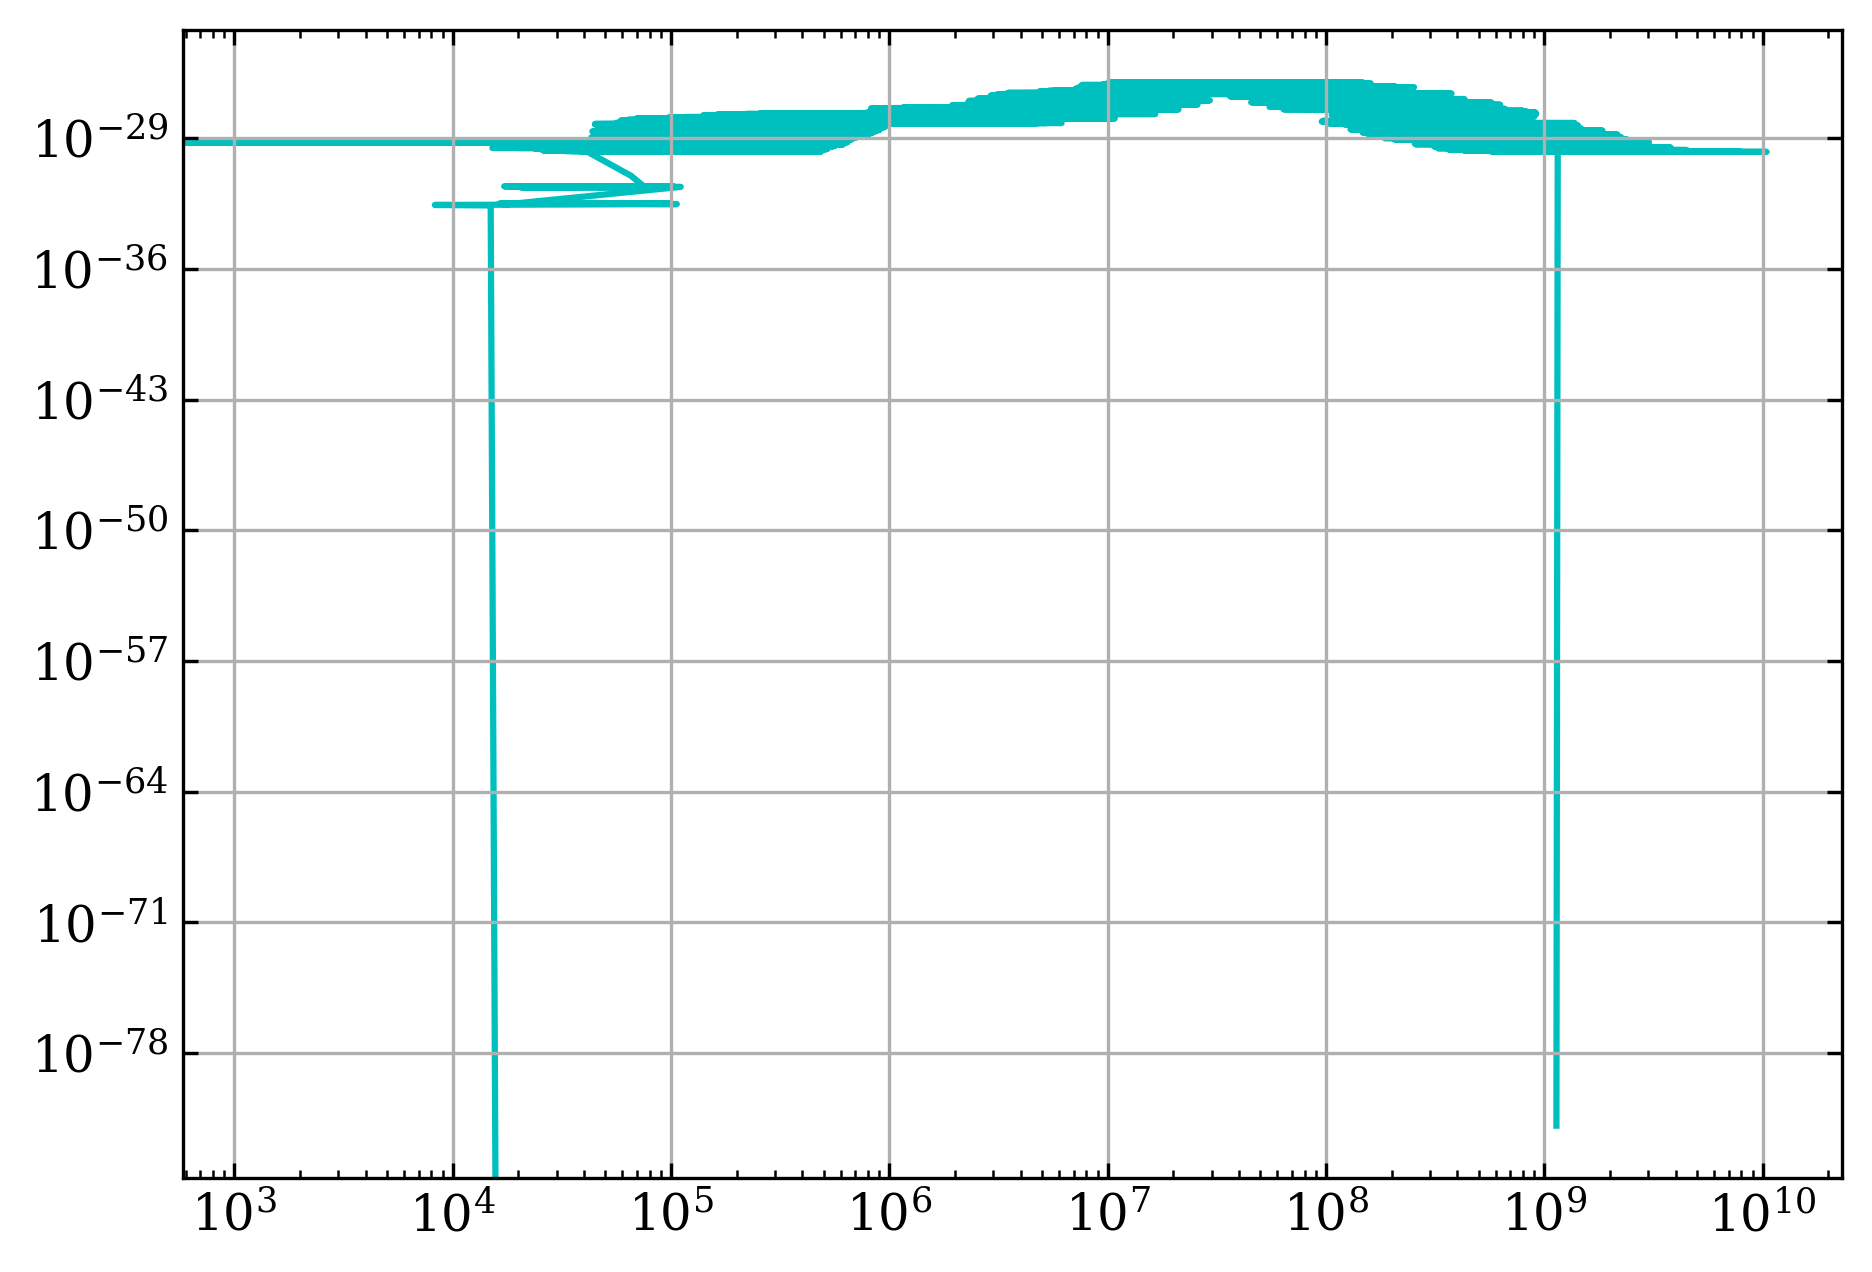

In [45]:
plt.loglog(wvl*(1+za),fnu_mod,color='c',alpha=1,label='model',zorder=1)

Text(0.5, 0, 'wavelength [Å]')

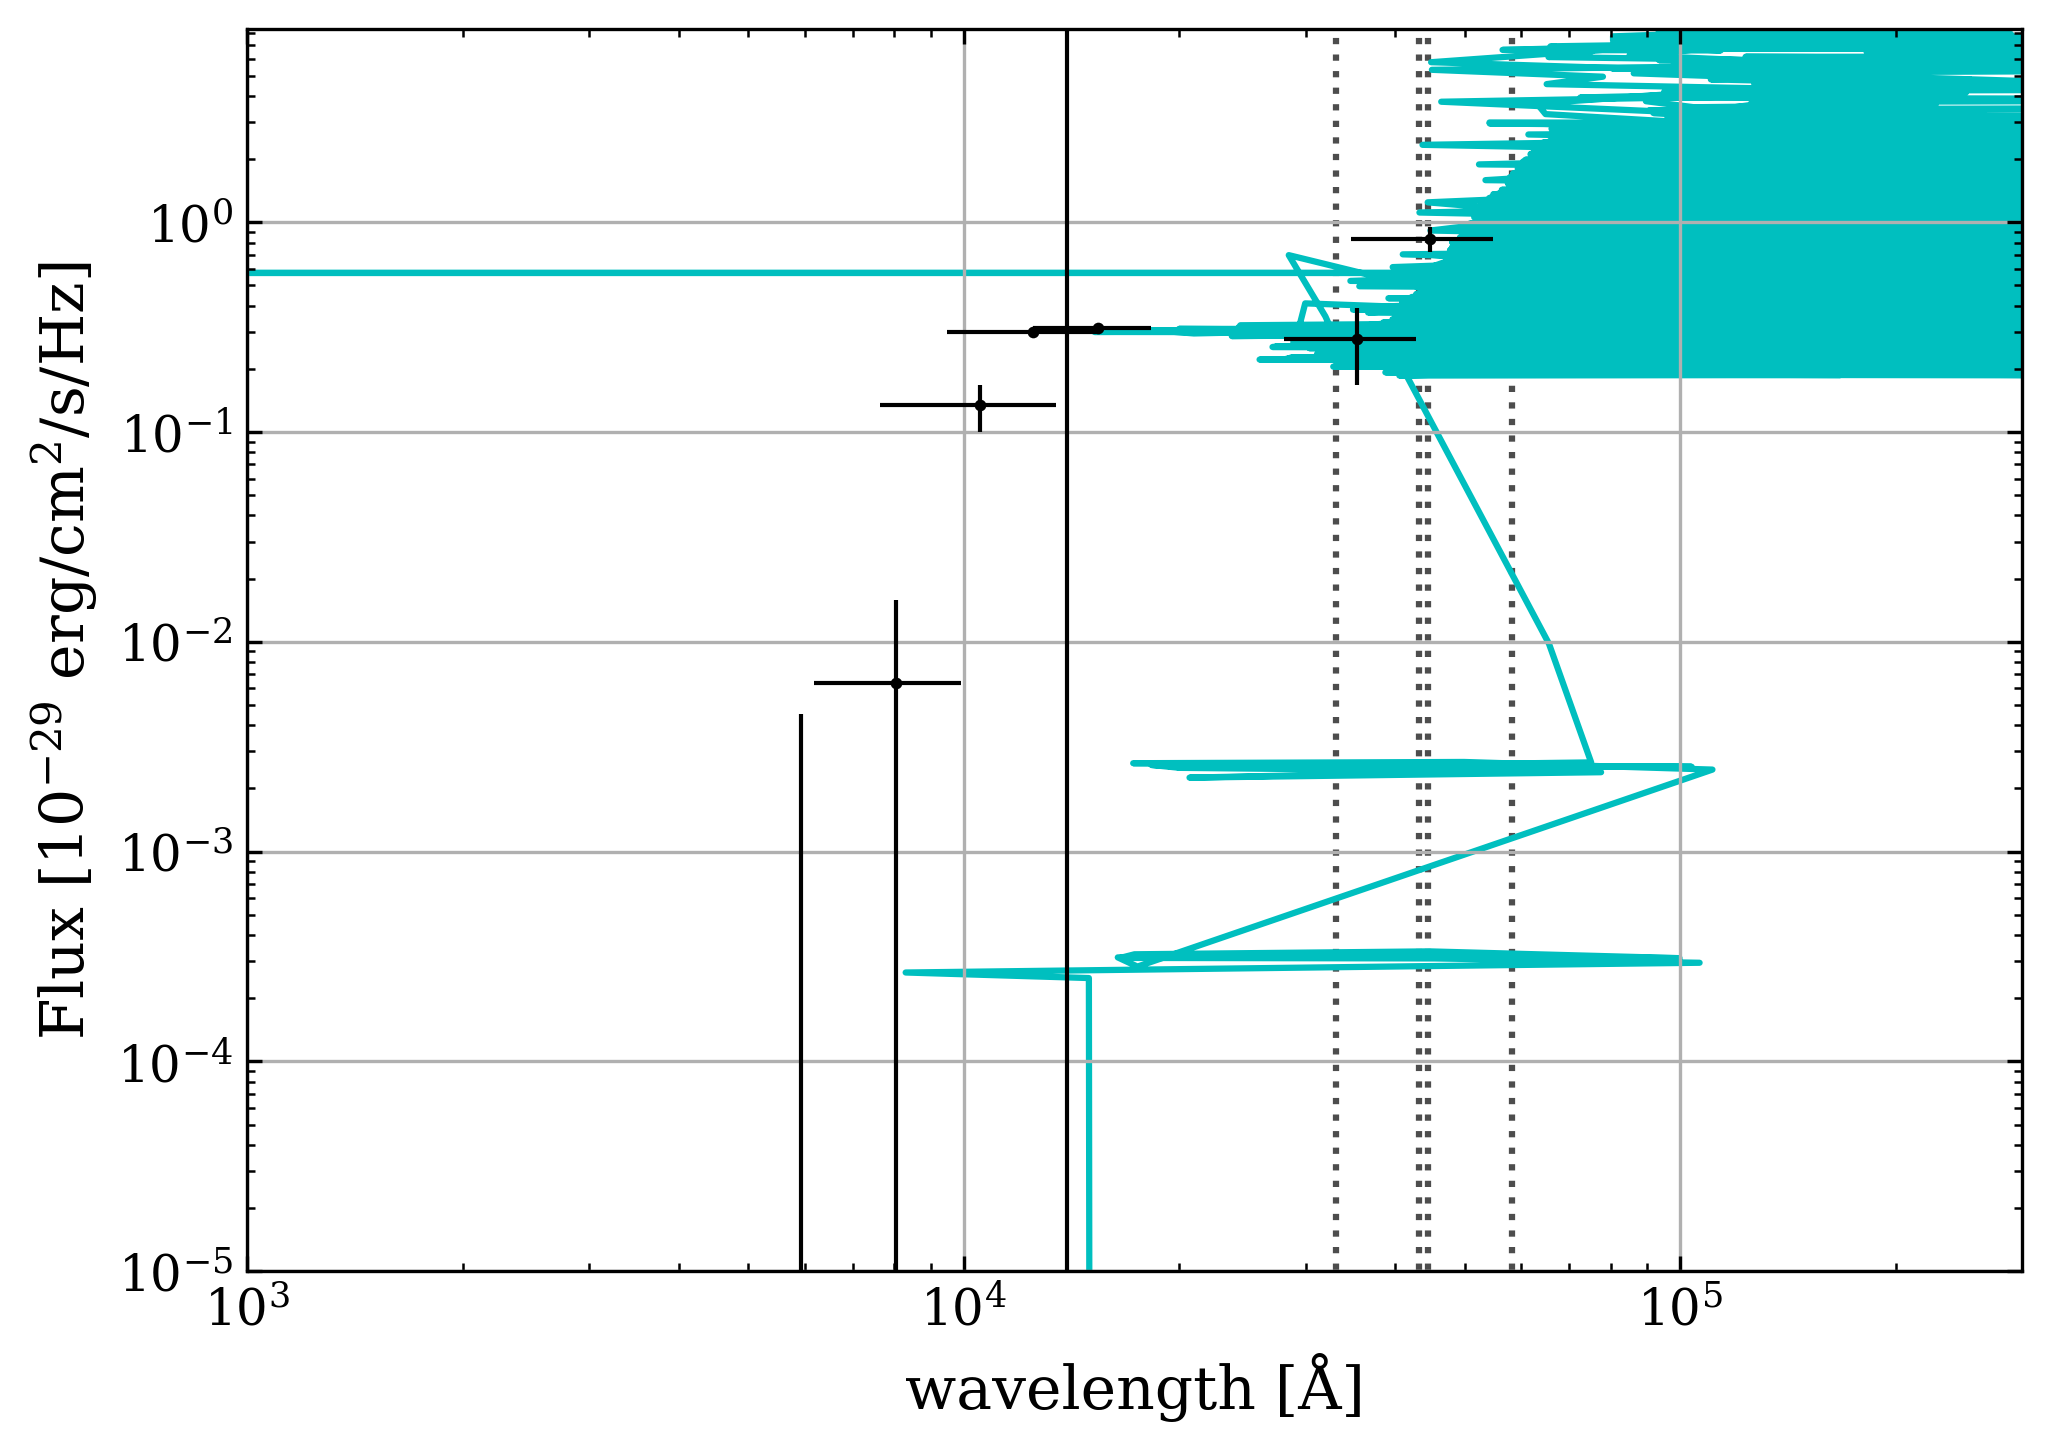

In [42]:


### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,300000) 
ax.set_ylim(1e-5,ymax)
ax.set_xlabel('wavelength [Å]')

/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_23263/156917301.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ymin,ymax)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


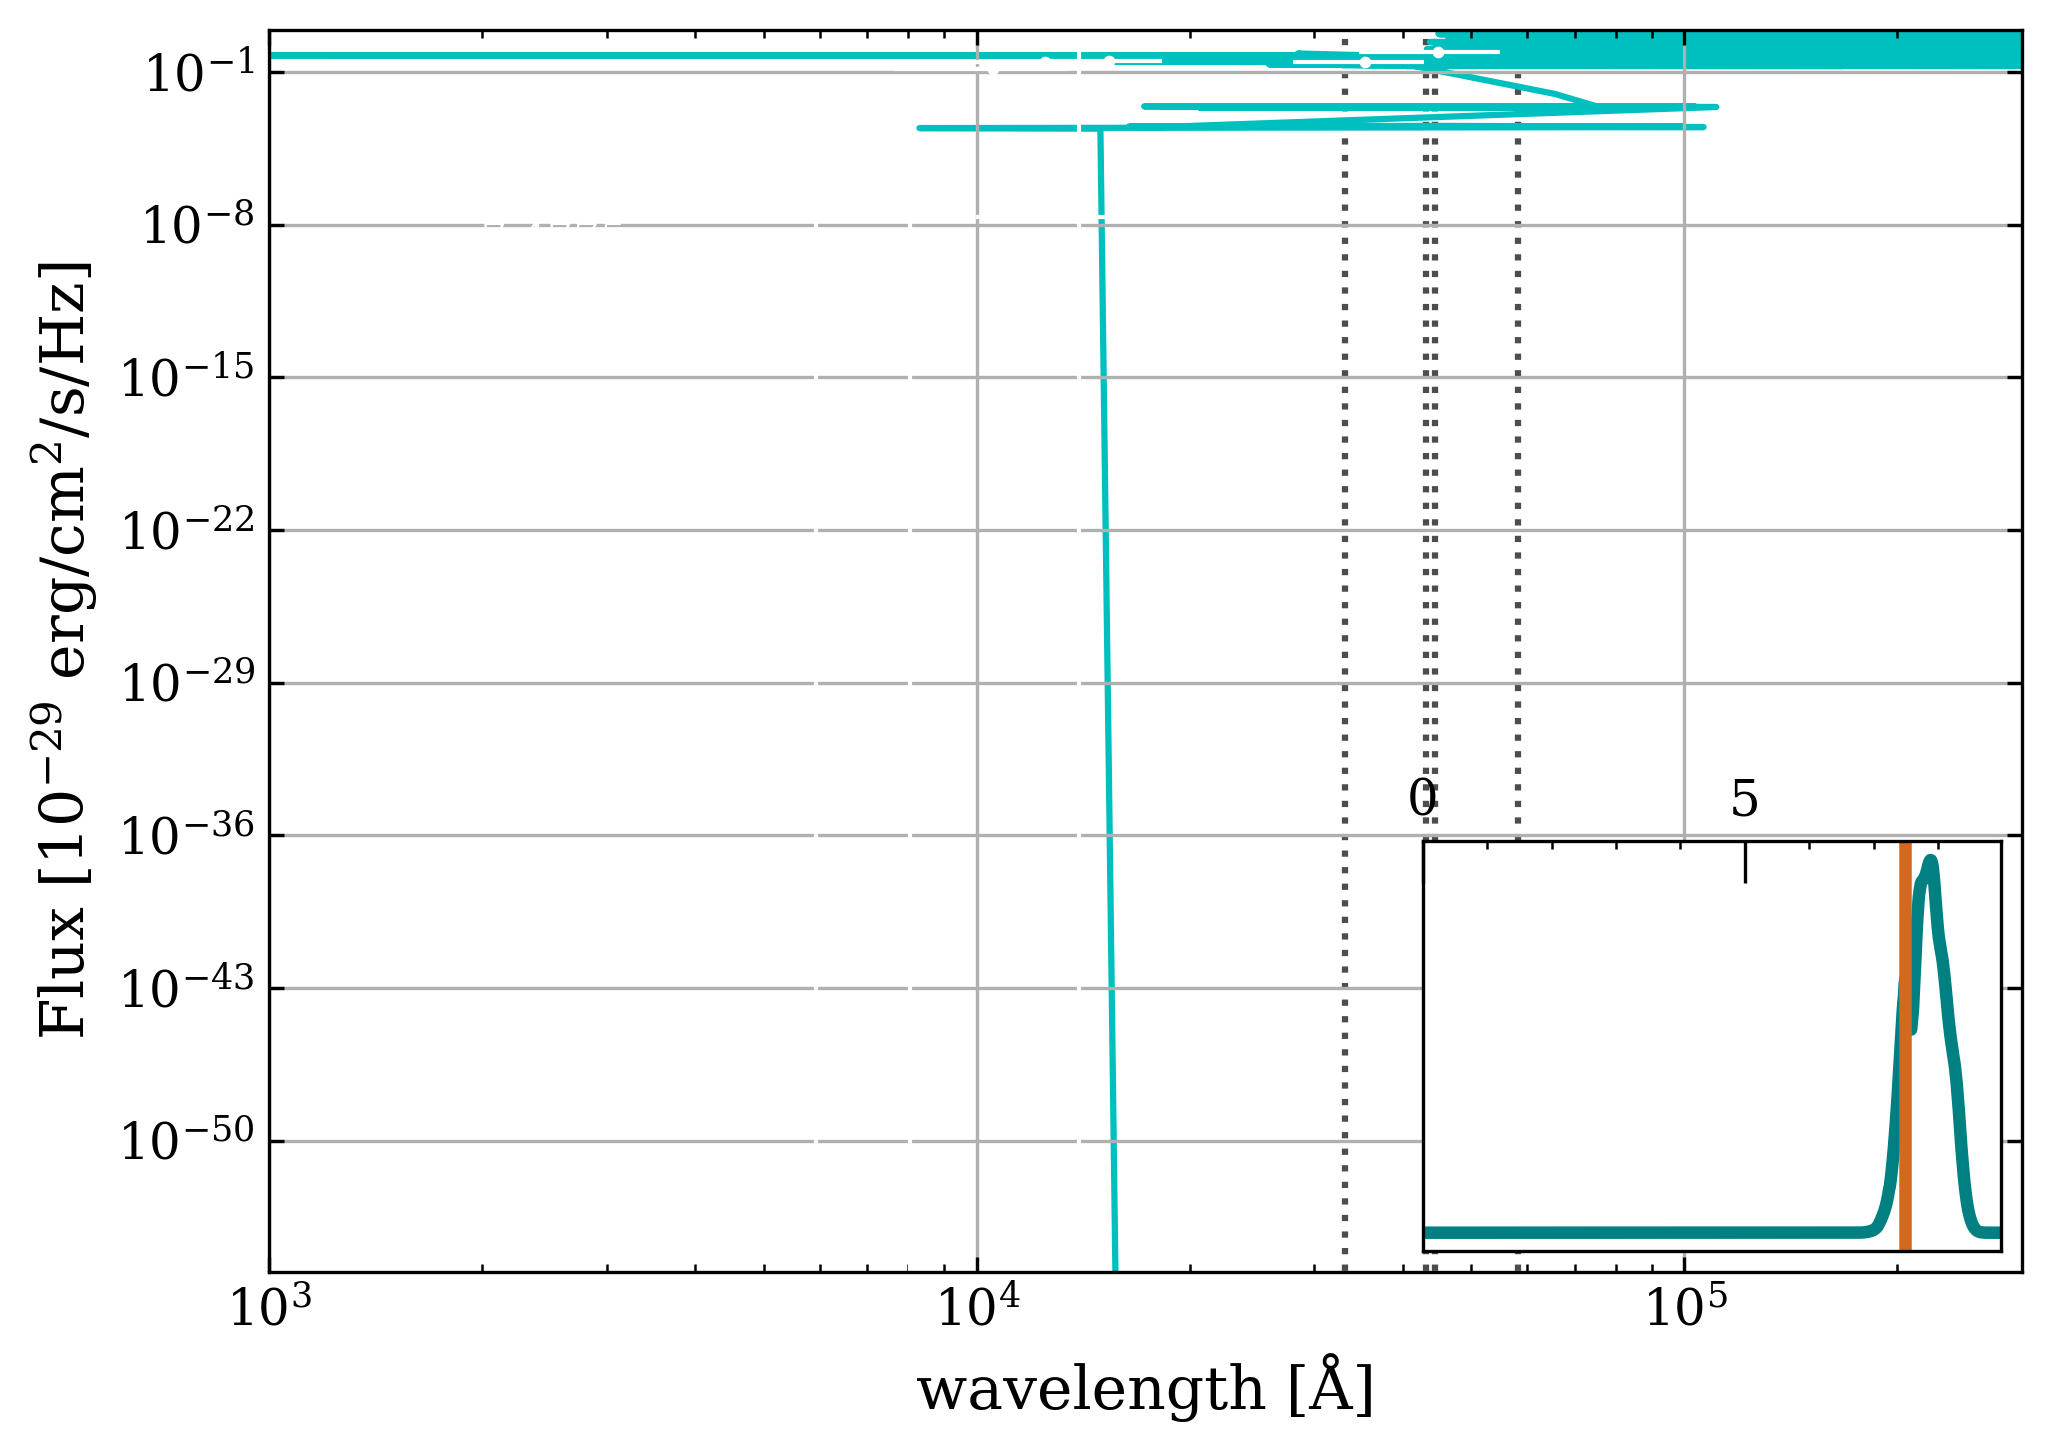

In [31]:


### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.w', ecolor = 'w', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,300000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# annotate
ax.annotate(text='photo-z='+str(np.round(za,2)),xy=(0.15,0.83),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='spec-z='+str(zguess),xy=(0.15,0.8),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='MUV='+str(np.round(MUV,2)),xy=(0.15,0.77),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='J mag='+str(np.round(Jmag.value,2)),xy=(0.15,0.74),xycoords='figure fraction',fontsize='small',color='w')


# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='lower right')
axin.plot(zarr,zpdf,c='teal',lw=3)
axin.axvline(zguess,c='chocolate',lw=3)
xmin = [za-1.5 if (za > 1.5)==True else 0][0]
axin.set_xlim(0,zguess+1.5)
axin.xaxis.tick_top()
axin.tick_params(size=10)
axin.yaxis.set_ticks([])
axin.xaxis.set_label_position('top') 
axin.grid(False)

In [359]:
catra = idl.ra[0]; catdec = idl.dec[0]
era, edec

(array([150.012783, 150.007107, 150.018292, ..., 150.2191  , 150.219695,
        150.233901]),
 array([2.048406, 2.048153, 2.048066, ..., 2.578641, 2.578976, 2.578395]))

In [367]:
idl.photz[0].pz[0][ind]

array([2.81692105e-01, 2.80940462e-01, 2.79309420e-01, ...,
       1.24544643e-26, 1.24546390e-26, 1.24548251e-26])

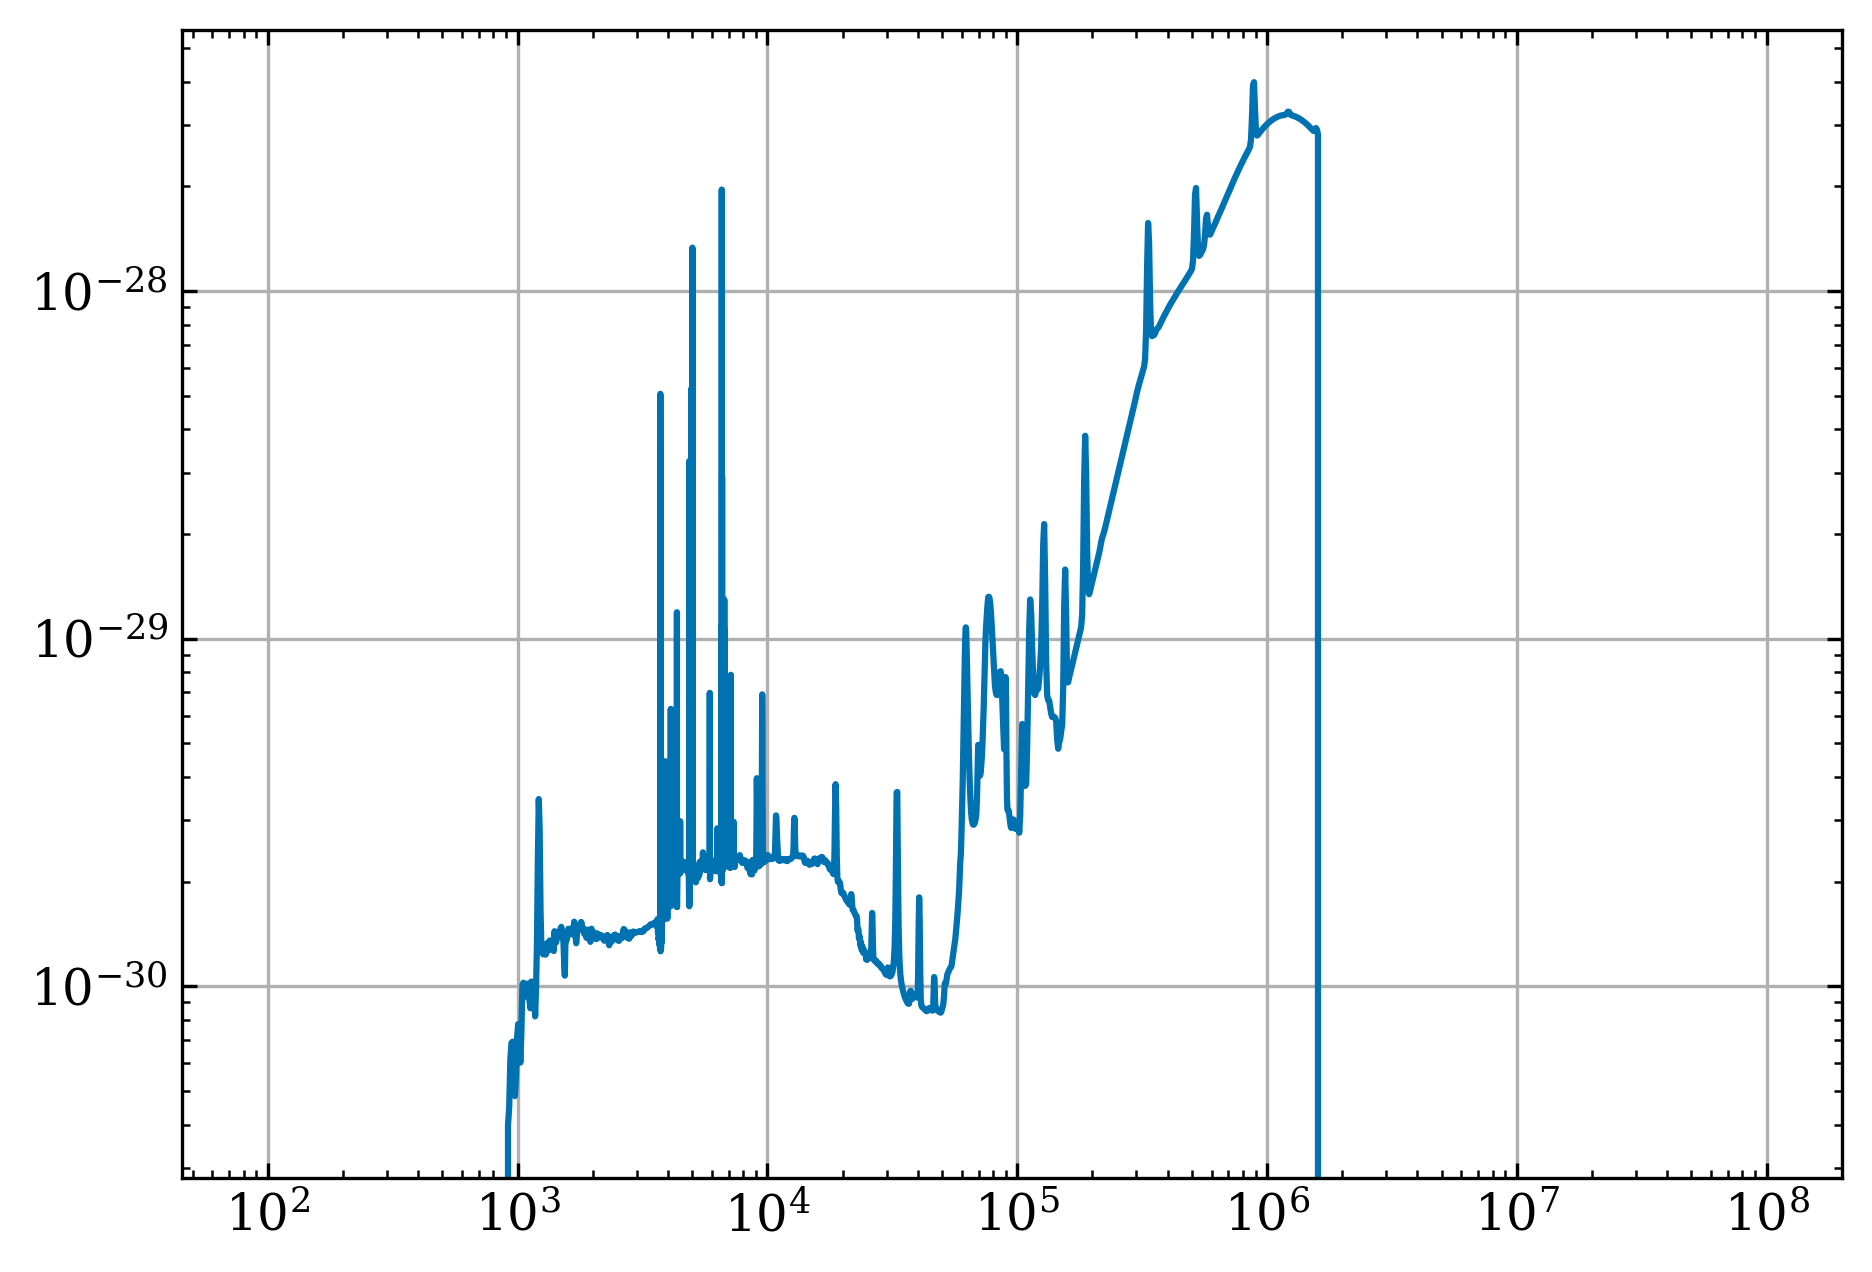

In [355]:
filt_lambda = idl.photz[0].templates[0].lam_rest[0]
model = idl.photz[0].templates[0].model[0][ind]
plt.loglog(filt_lambda,model)

In [226]:
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
wra = float(notes['objra'][idx]); wdec = float(notes['objdec'][idx])
wra,wdec,zguess

(215.05033, 53.00745, 7.4775)

In [ ]:
# select object
obj_name = sys.argv[1]
idx = np.where(cat0['obj']==obj_name)[0]
targ = cat0[idx]
zguess = float(targ['zguess'])
print('working on object',obj_name,'with zguess = ',zguess)

# print best fits params of interest
print(targ['lp_zBEST'])
print('')
print(targ['lp_MFUV'])

# find UV mag
Jmag = targ['UVISTA_J_MAG'] # apparent J mag
MUV = Jmag-cosmo.distmod(zguess)+(2.5*np.log10(1+zguess)) # abs UV mag

print("check phot MUV: ",targ['UVISTA_J_MAG']-cosmo.distmod(targ['lp_zBEST'])+(2.5*np.log10(1+targ['lp_zBEST'])))
print("")
print("spec MUV: ",MUV)


In [227]:
c = SkyCoord(ra=era*u.degree, dec=edec*u.degree)
catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
ind, d2d, d3d = catalog.match_to_catalog_sky(c)

In [235]:
egs.cat.flux[0]

rec.array([(array([ 1.52353488e-06, -1.42512645e-05, -2.38224976e-06, ...,
                   3.83760215e+01,  3.87210972e+01,  1.23829187e+01]), array([ 3.36949937, 92.98342123, 70.61395741, ..., 49.16668131,
                  44.26292198, 13.28607057]), array([1.92369701e-40, 3.34556192e-40, 1.26913782e-40, ...,
                  4.22012191e-34, 2.71238300e-09, 2.88759677e-17]), array([ 11.52469983, 207.19276054,  67.009576  , ...,  21.63734005,
                   23.52689232,  20.47142474]), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                  2.81443235e-19, 2.94346898e-01, 4.34379991e+00]), array([133.22484455, 270.99519014, 106.41097951, ..., 114.77306924,
                   47.07423259,  31.22904469]), array([   0.        ,    0.        ,    0.        , ...,  100.21799511,
                  -216.89640836, -159.11810496]), array([  0.        ,   0.        ,   0.        , ..., 185.7190913 ,
                  -16.47862488, -36.98978437]))                   

In [360]:
idl.flux[0].dtype.names

('FV', 'FI', 'FY', 'FJ', 'FJH', 'FH', 'F36', 'F45')

In [361]:
za = idl.photz[0].za[0][ind]
flux = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.uJy
fluxerr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.uJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

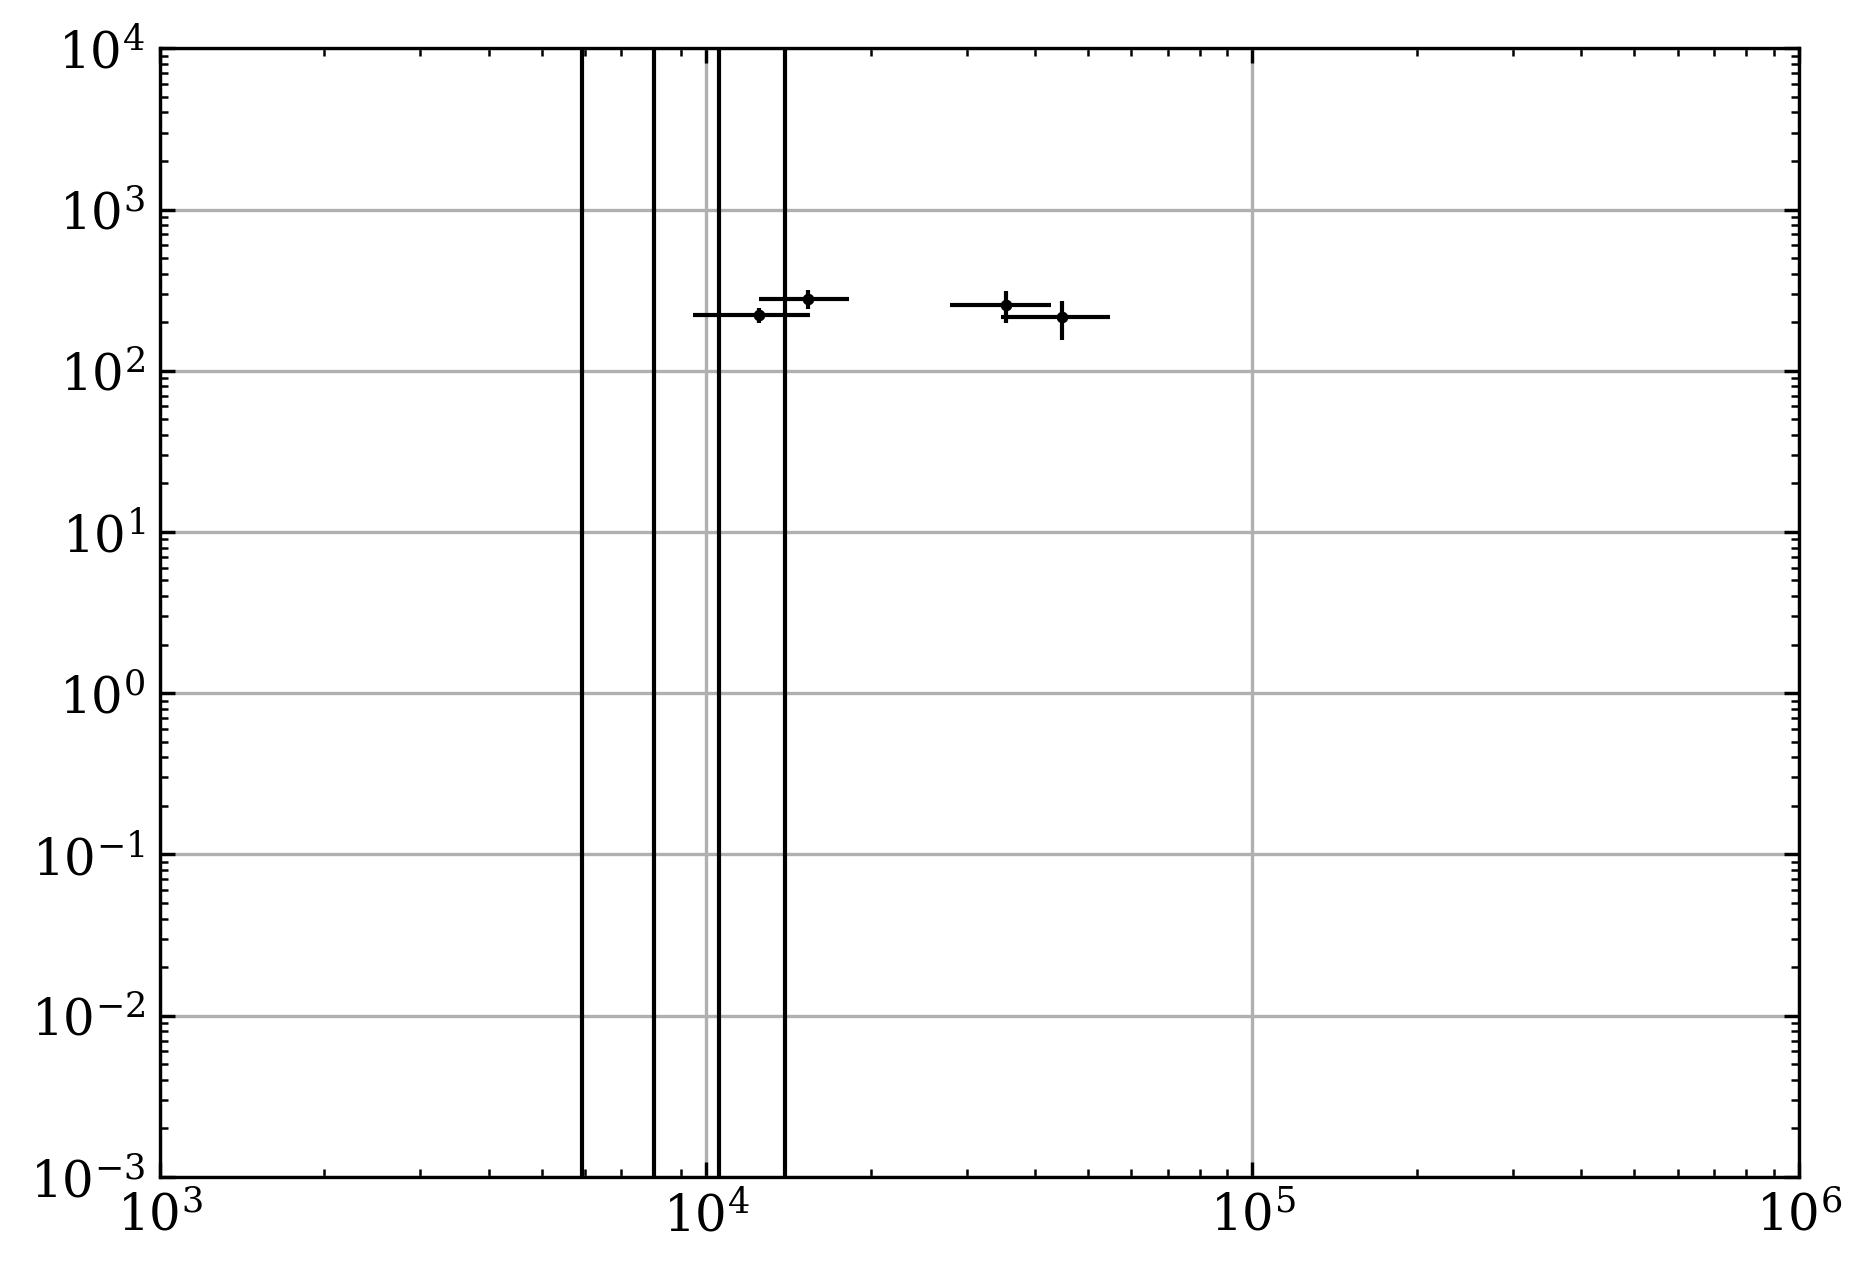

In [362]:
#plt.plot(model_wav, model_flux*1e29)
plt.errorbar(filt_lambda.to(u.AA),flux.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fluxerr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
plt.xlim(1e3,1e6)
plt.ylim(1e-3,1e4)
plt.xscale('log')
plt.yscale('log')

In [207]:
file = '../cosmos_werls_sample.mosfire.sav'
sav = scipy.io.readsav(file)

In [98]:
np.where(sav.all.name==b'M_WP551495')

(array([983]),)

In [212]:
file = '../../idl/CAND_M8502_candels_entry.sav'
sav = scipy.io.readsav(file)

In [213]:
sav

{'dat': rec.array([(150.172758, 2.206212, 7.79, -1., 6.49819383, -1., 7.53118128, 2.32225227e-08, 5.40473747, 5.89125276, 1.8, 5.40473747, 7.79, 2.01, 8.03, array([0.606, 0.814, 1.05 , 1.25 , 1.4  , 1.6  , 3.6  , 4.5  ],
                  dtype=float32), array([-3.22331073e+01,  1.40969327e+02, -9.74856377e-13,  1.32588204e+03,
                   -2.85465931e-03,  2.14562747e+03,  1.27247498e+04,  1.94657142e+04]), array([4.50264421e+01, 6.34334306e+01, 7.74898117e+13, 9.79961901e+01,
                   5.33941534e+13, 9.70762488e+01, 6.65441362e+01, 6.88992472e+01]), array([1.000e-02, 2.000e-02, 3.000e-02, ..., 1.498e+01, 1.499e+01,
                   1.500e+01]), array([3.53532434e-91, 5.99154117e-91, 6.33274751e-91, ...,
                   9.24858900e-75, 9.24858670e-75, 9.24860600e-75]), array([73.89999965, 26.027188  , 73.89999965, 23.59373735, 73.89999965,
                   23.07111376, 21.13837644, 20.67682371]), array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07

In [215]:
sav.dat.wavrest[0].size,sav.dat.model[0].size,sav.dat.za[0].size
sav.dat.za[0]

7.789999999999878

photometric redshift =  7.79


(0.0, 6.0)

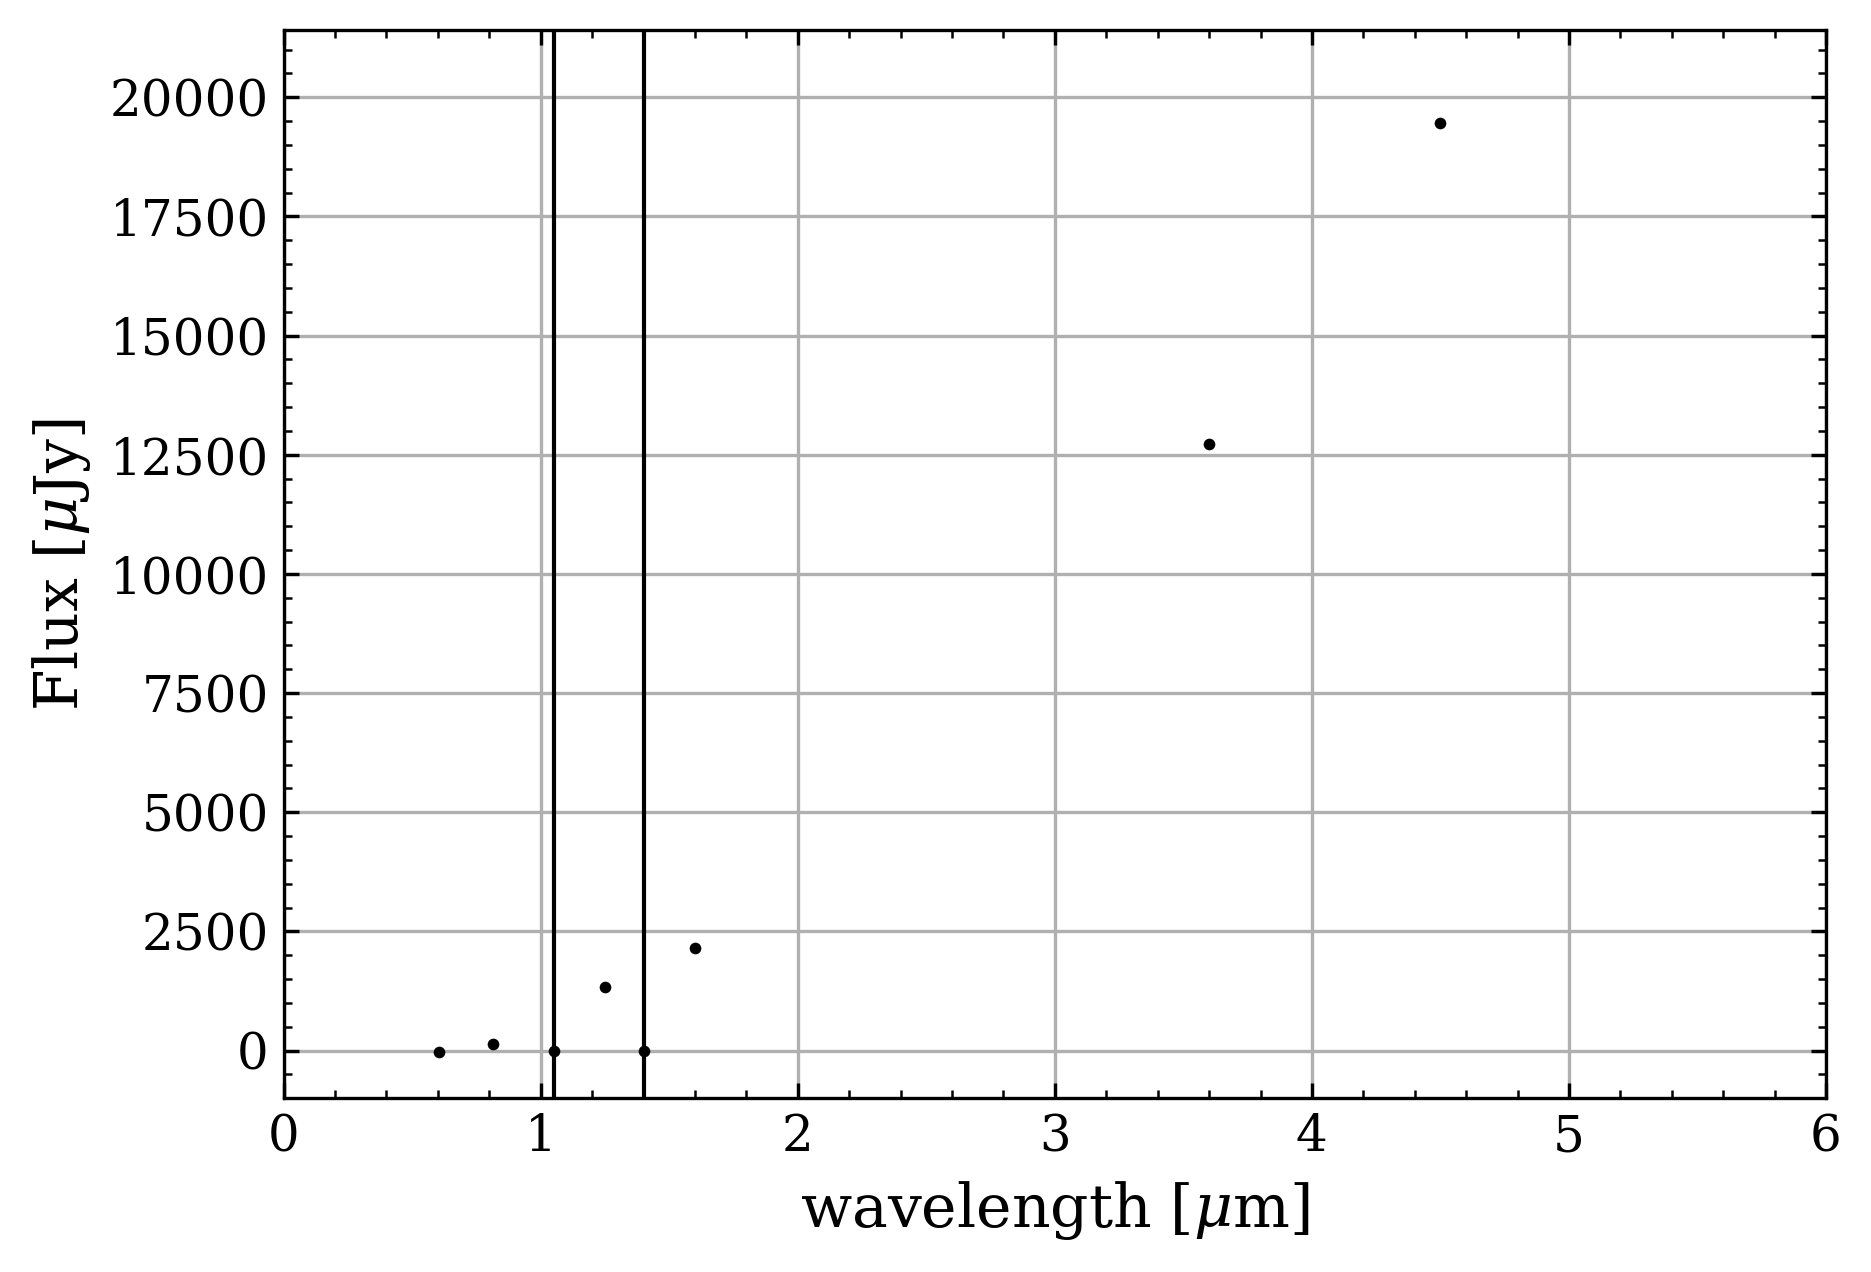

In [103]:
# plot sed
plt.ylabel('Flux [$\mu$Jy]')
plt.errorbar(sav.dat.wave[0],sav.dat.flux[0],xerr=None,yerr=sav.dat.fluxerr[0],fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
plt.plot(sav.dat.wavrest[0]*(1+sav.dat.za[0]), sav.dat.model[0])
zp = sav.dat.zpeak[0]
print("photometric redshift = ",np.round(sav.dat.za[0],2))
plt.xlabel('wavelength [$\mu$m]')
ymax = 1.1*np.max(sav.dat.flux[0])
plt.ylim(-1000,ymax)
plt.xlim(0,6)
#plt.yscale('log')

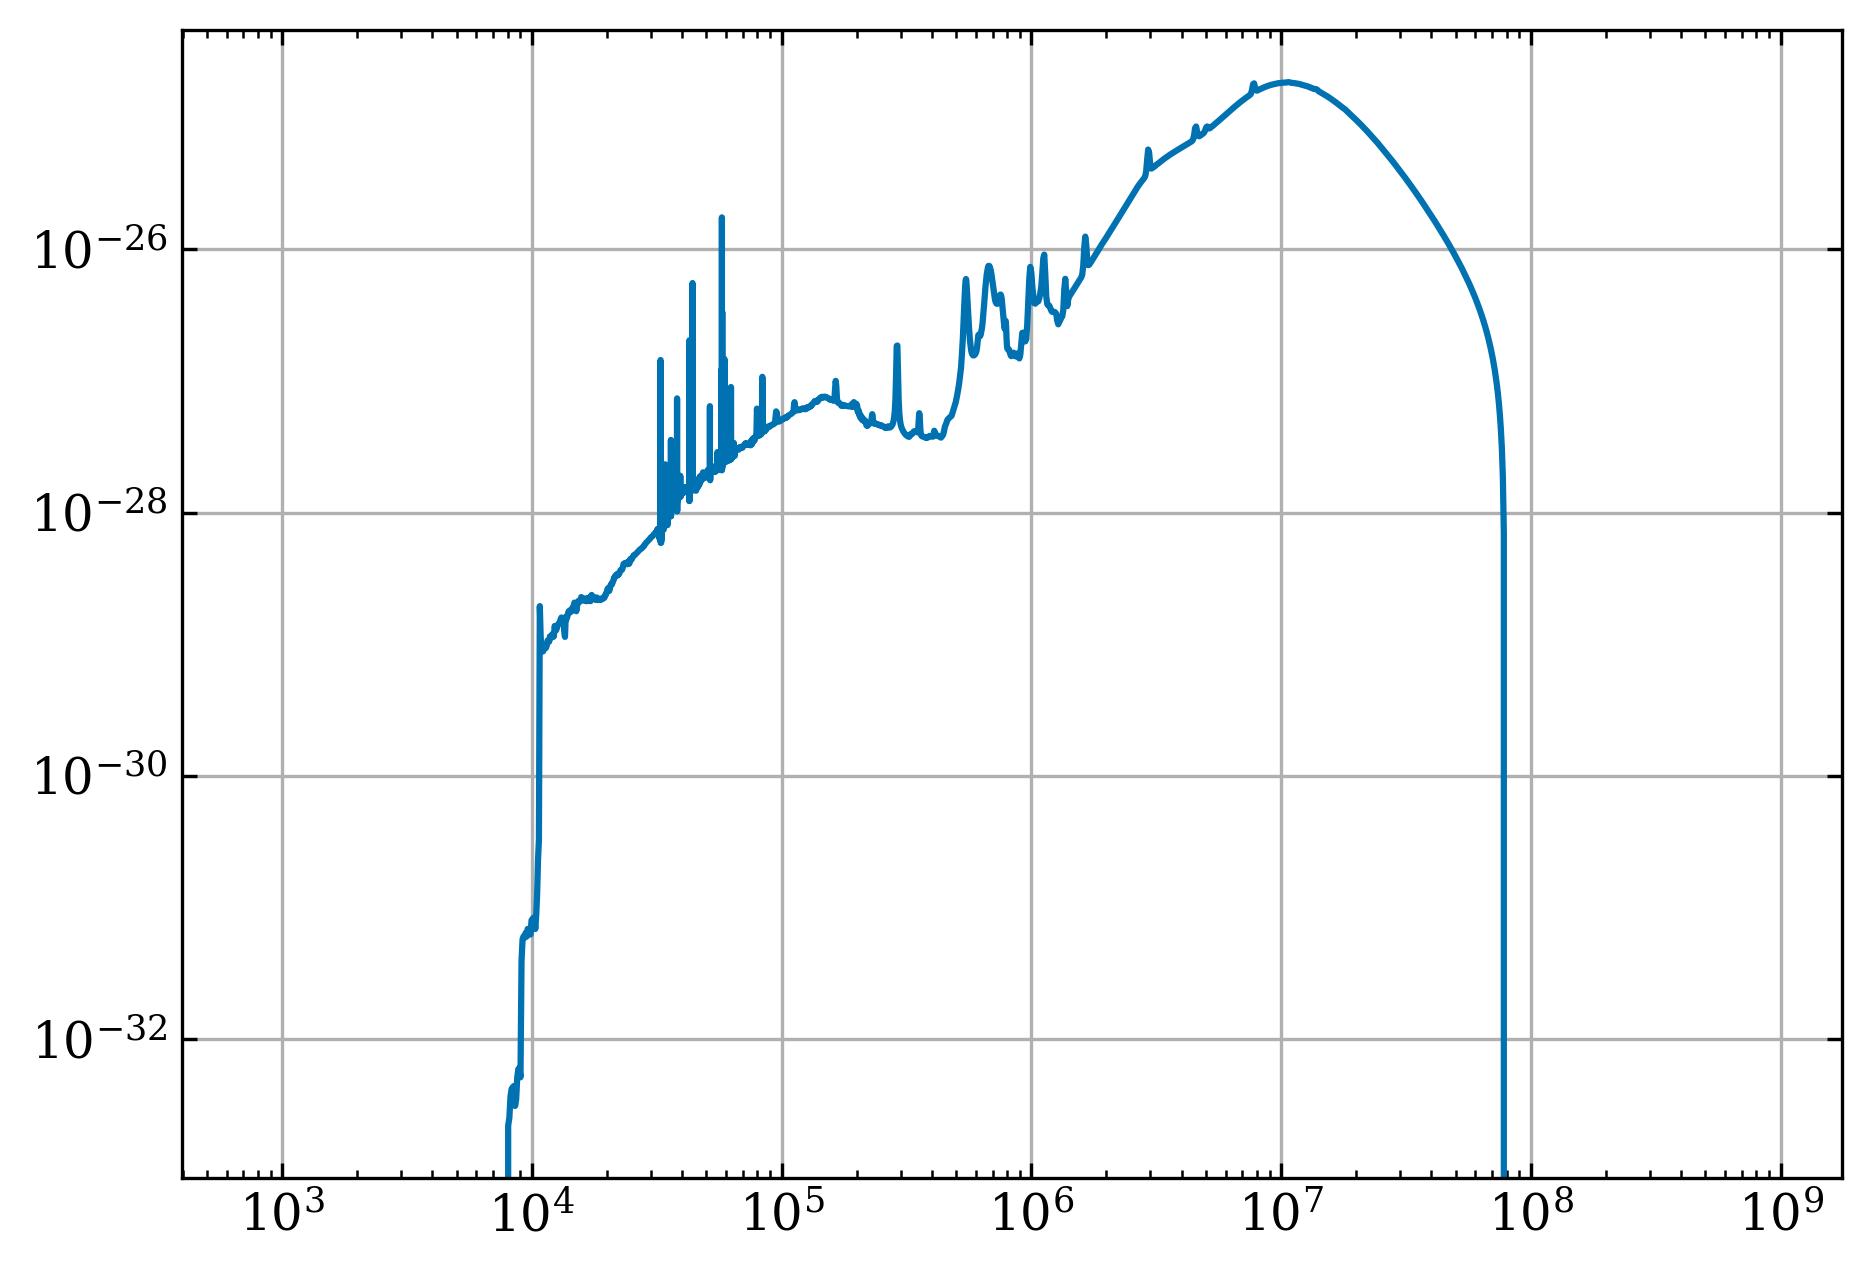

In [135]:
plt.plot(sav.dat.wavrest[0]*(1+sav.dat.za[0]), sav.dat.model[0])
#plt.xlim(5e3,1e7)
plt.xscale('log')
plt.yscale('log')

In [209]:
model_wav = (sav.dat.wavrest[0]*(1+sav.dat.za[0]))*u.erg/u.s/u.Hz/u.cm**2
model_flux = (sav.dat.model[0])*u.AA
obs_wav = (sav.dat.wave[0])*u.um
obs_flux = (sav.dat.flux[0])*u.nJy
obs_fluxerr = (sav.dat.fluxerr[0])*u.nJy

KeyError: 'dat'

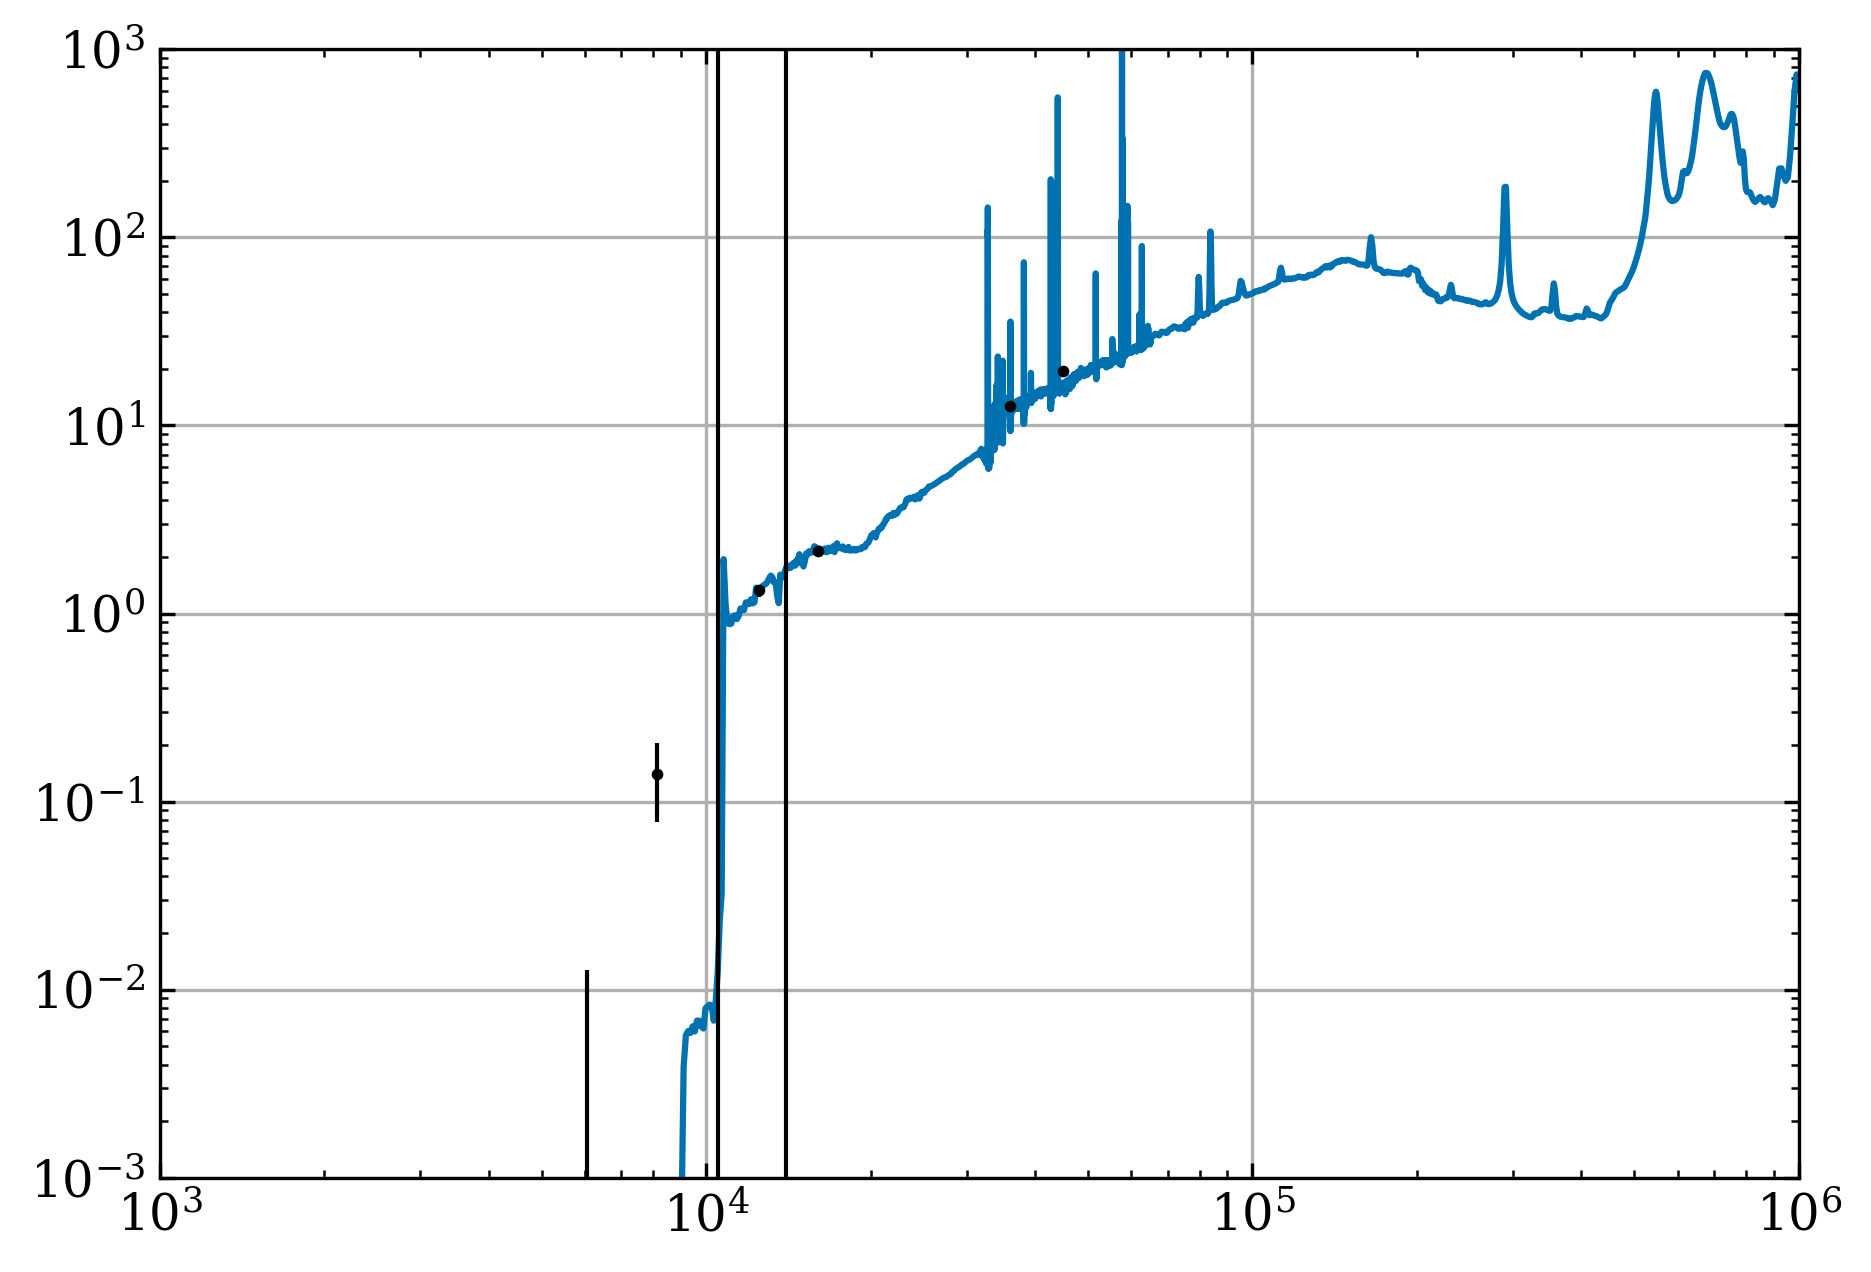

In [134]:
plt.plot(model_wav, model_flux*1e29)
plt.errorbar(obs_wav.to(u.AA),obs_flux.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=None,yerr=obs_fluxerr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
plt.xlim(1e3,1e6)
plt.ylim(1e-3,1e3)
plt.xscale('log')
plt.yscale('log')

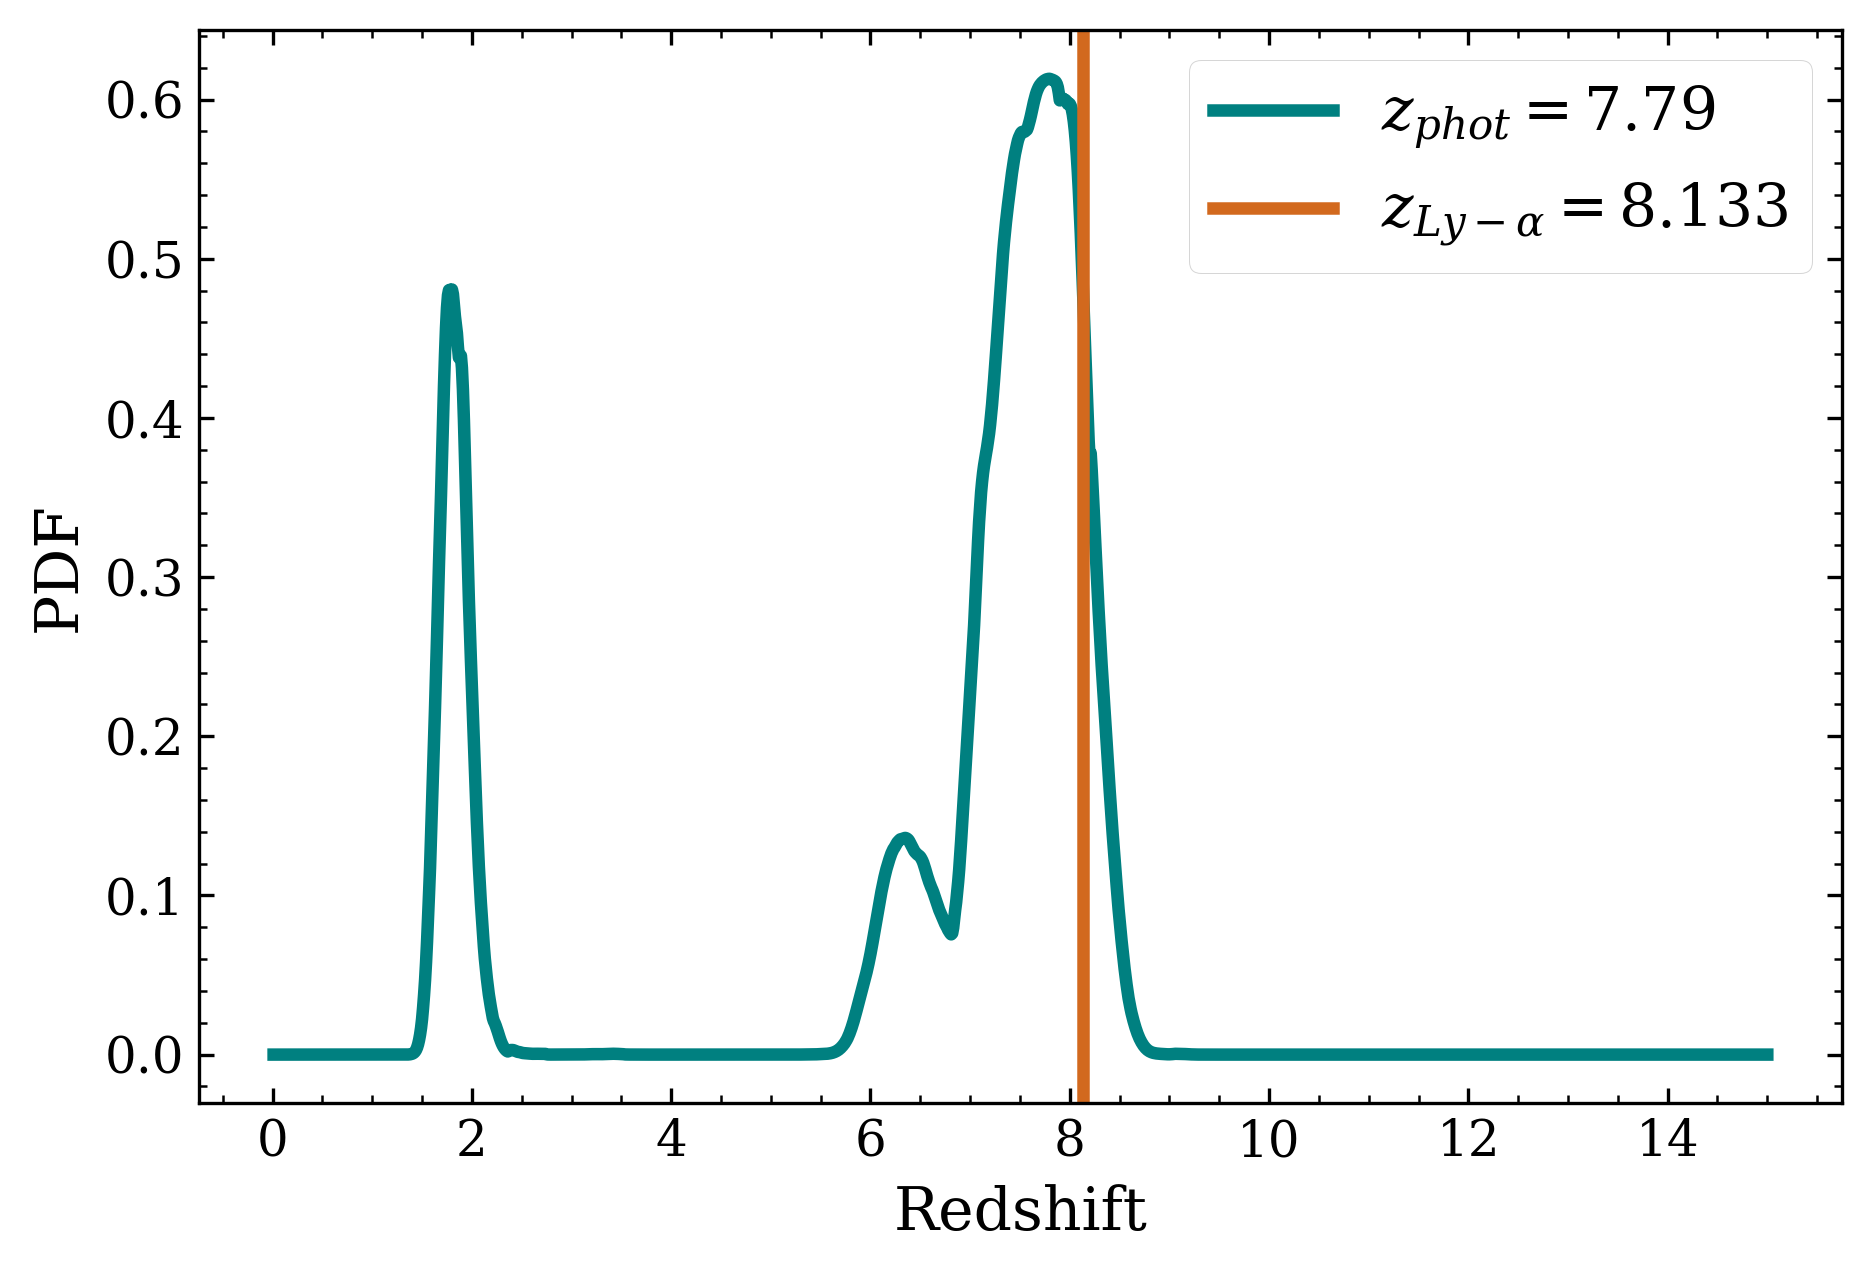

In [268]:
# plot redshift pdf
zguess = 8.133
plt.plot(sav.dat.zgrid[0],sav.dat.pzarr[0],c='teal',lw=3,label=r'$z_{phot}=$'+str(np.round(sav.dat.za[0],2)))
plt.axvline(zguess,c='chocolate',lw=3,label=r'$z_{Ly-\alpha}=$'+str(zguess))
plt.ylabel('PDF')
plt.xlabel('Redshift')
plt.grid(False)
plt.legend(fontsize='large')
plt.show()

working on object B_WPCAND-6931 with zguess =  8.195


/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_56073/2251839255.py:88: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ymin,ymax)
/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_56073/2251839255.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_candels_sed.png',dpi=500)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


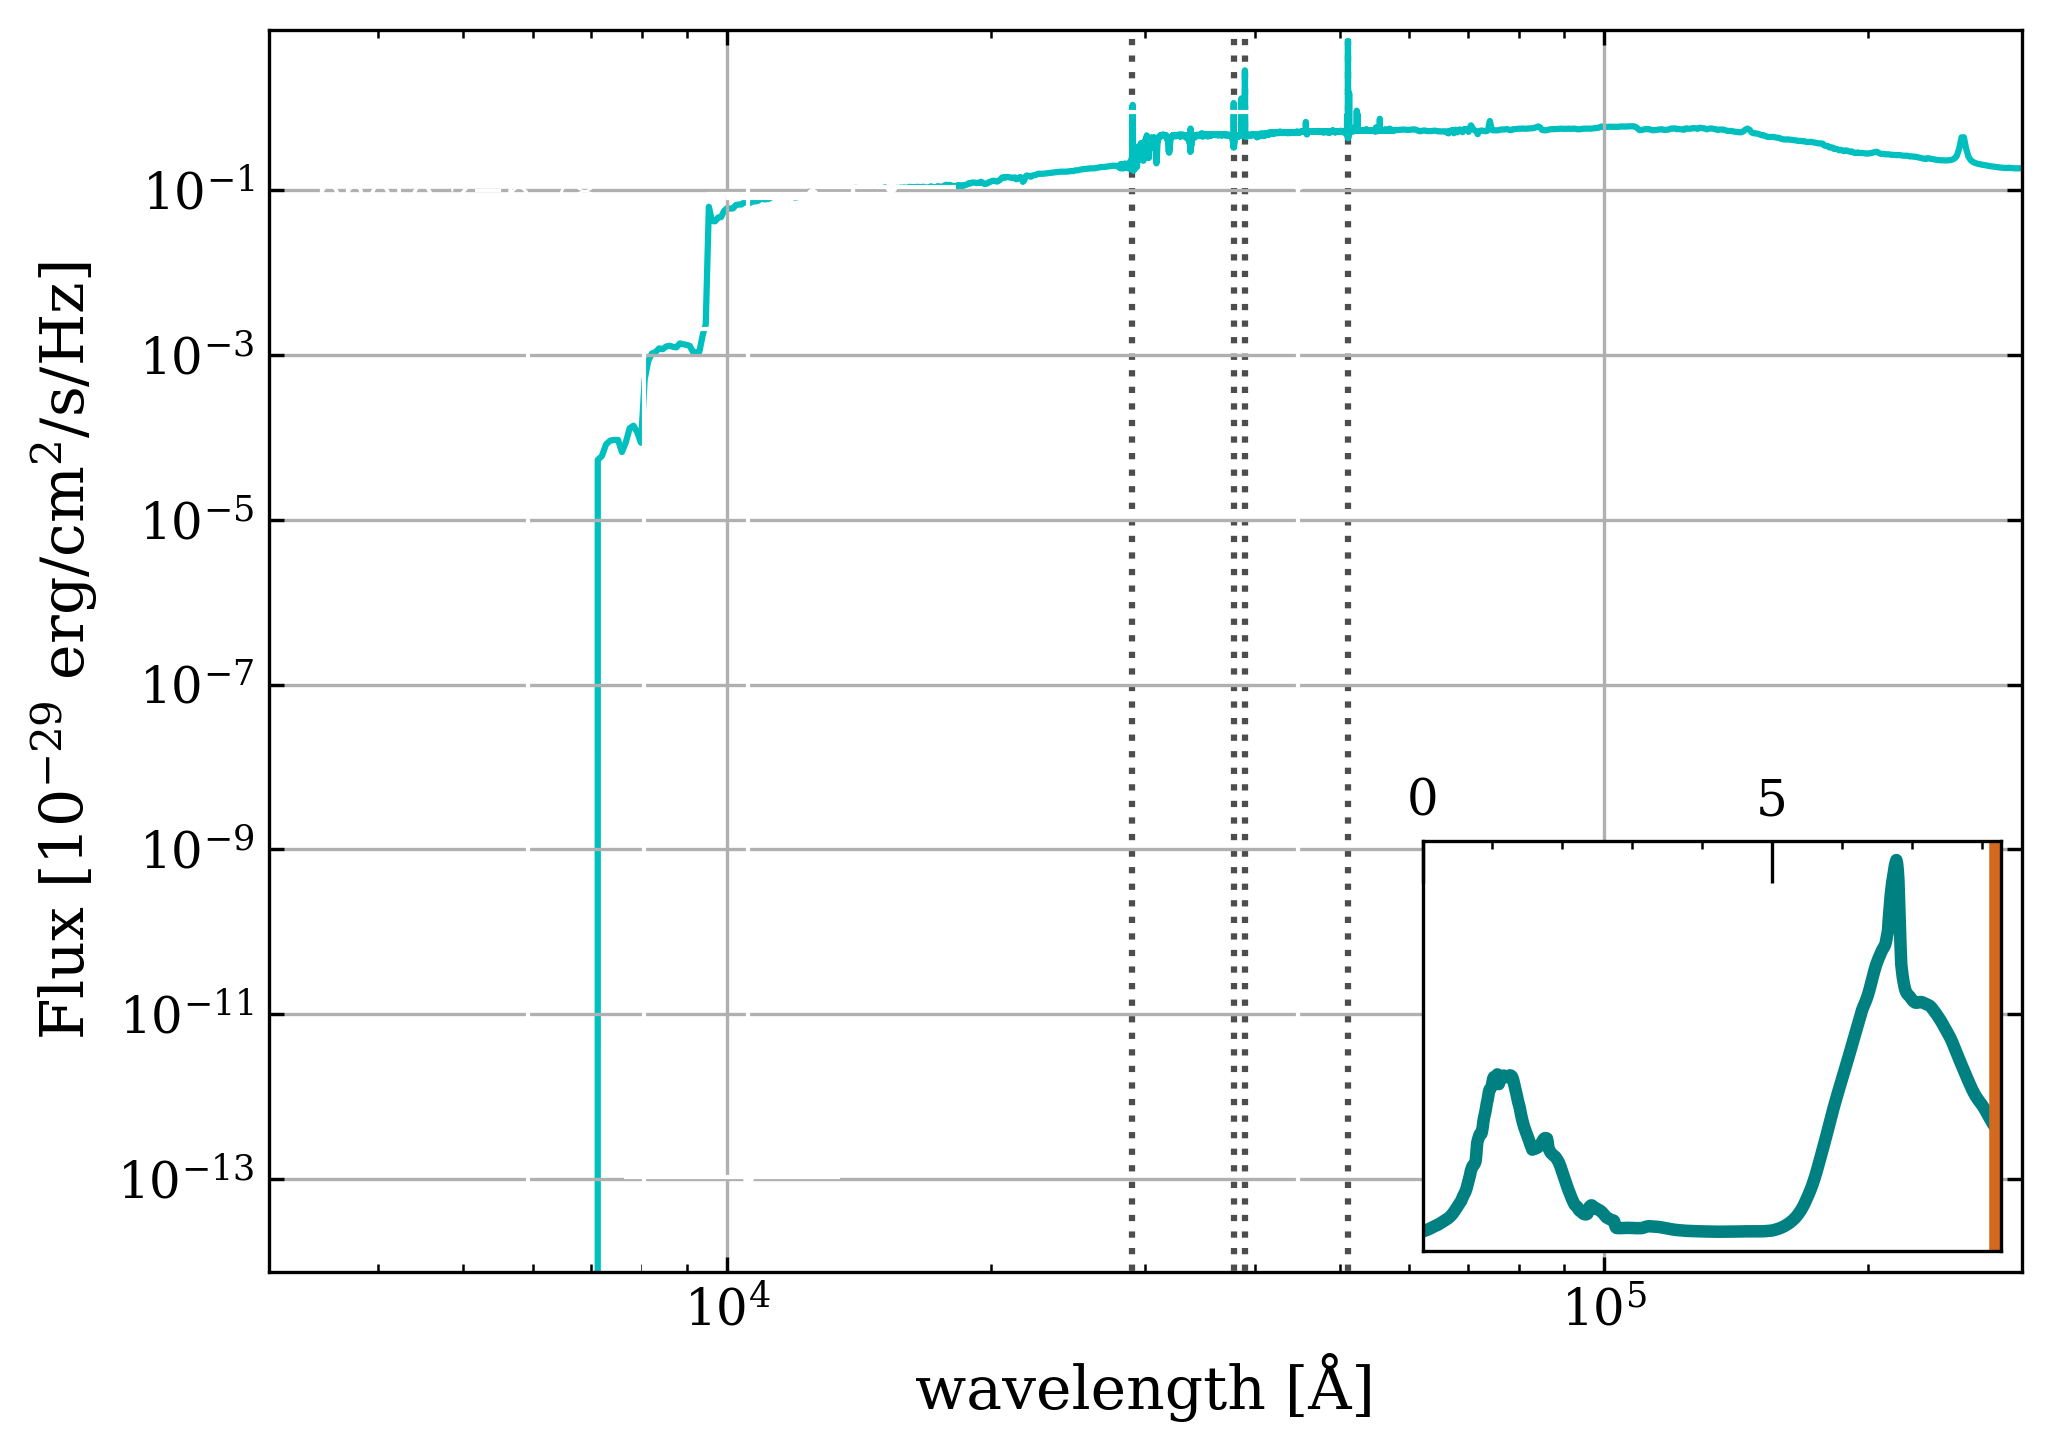

In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  1 12:39:35 2022

@author: 0cooper
"""

# the basics
import sys
import numpy as np 
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io
from astropy import units as u 
from astropy.table import Table
from astropy.coordinates import SkyCoord
#plt.style.use('../cooper-presentation.mplstyle')


# select object
obj_name = 'B_WPCAND-6931'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
wra = float(notes['objra'][idx]); wdec = float(notes['objdec'][idx])
print('working on object',obj_name,'with zguess = ',zguess)


if notes['mask'][idx][0][:-2] == 'wmmc':
    file = '/Users/oc4858/werls/COSMOS_F21.idl'
    idl = scipy.io.readsav(file).cat
elif notes['mask'][idx][0][:-2] == 'wmmu':
    file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/uds/UDS_candidates_all.idl'
    idl = scipy.io.readsav(file).fobj
#elif notes['mask'][idx][0][:-2] == 'wmme':
    #ddir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_'

# load catalog ra/dec
catra = idl.ra[0]; catdec = idl.dec[0]
# crossmatch
c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
ind, d2d, d3d = catalog.match_to_catalog_sky(c)

# load fluxes
fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

# load best fit sed
wvl = idl.photz[0].lam_rest_model[0]*u.AA
fnu_mod = idl.photz[0].model[0][ind]*u.erg/u.s/u.Hz/u.cm**2

# load zpdf
za = idl.photz[0].za[0][ind]
zarr = idl.photz[0].zgrid[0]
zpdf = idl.photz[0].pz[0][ind]
sz = idl.specz[0][ind]
if sz != -1.: 
    print('This object has a spec-z already! z =',sz)


### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.w', ecolor = 'w', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3000,300000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# annotate
ax.annotate(text='photo-z='+str(np.round(za,2)),xy=(0.15,0.83),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='spec-z='+str(zguess),xy=(0.15,0.8),xycoords='figure fraction',fontsize='small',color='w')
#ax.annotate(text='MUV='+str(np.round(MUV[0],2)),xy=(0.15,0.77),xycoords='figure fraction',fontsize='small',color='w')
#ax.annotate(text='J mag='+str(np.round(Jmag[0],2)),xy=(0.15,0.74),xycoords='figure fraction',fontsize='small',color='w')


# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='lower right')
axin.plot(zarr,zpdf,c='teal',lw=3)
axin.axvline(zguess,c='chocolate',lw=3)
xmin = [za-1.5 if (za > 1.5)==True else 0][0]
axin.set_xlim(0,za+1.5)
axin.xaxis.tick_top()
axin.tick_params(size=10)
axin.yaxis.set_ticks([])
axin.xaxis.set_label_position('top') 
axin.grid(False)


plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_candels_sed.png',dpi=500)

/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_56073/738688372.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ymin,ymax)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


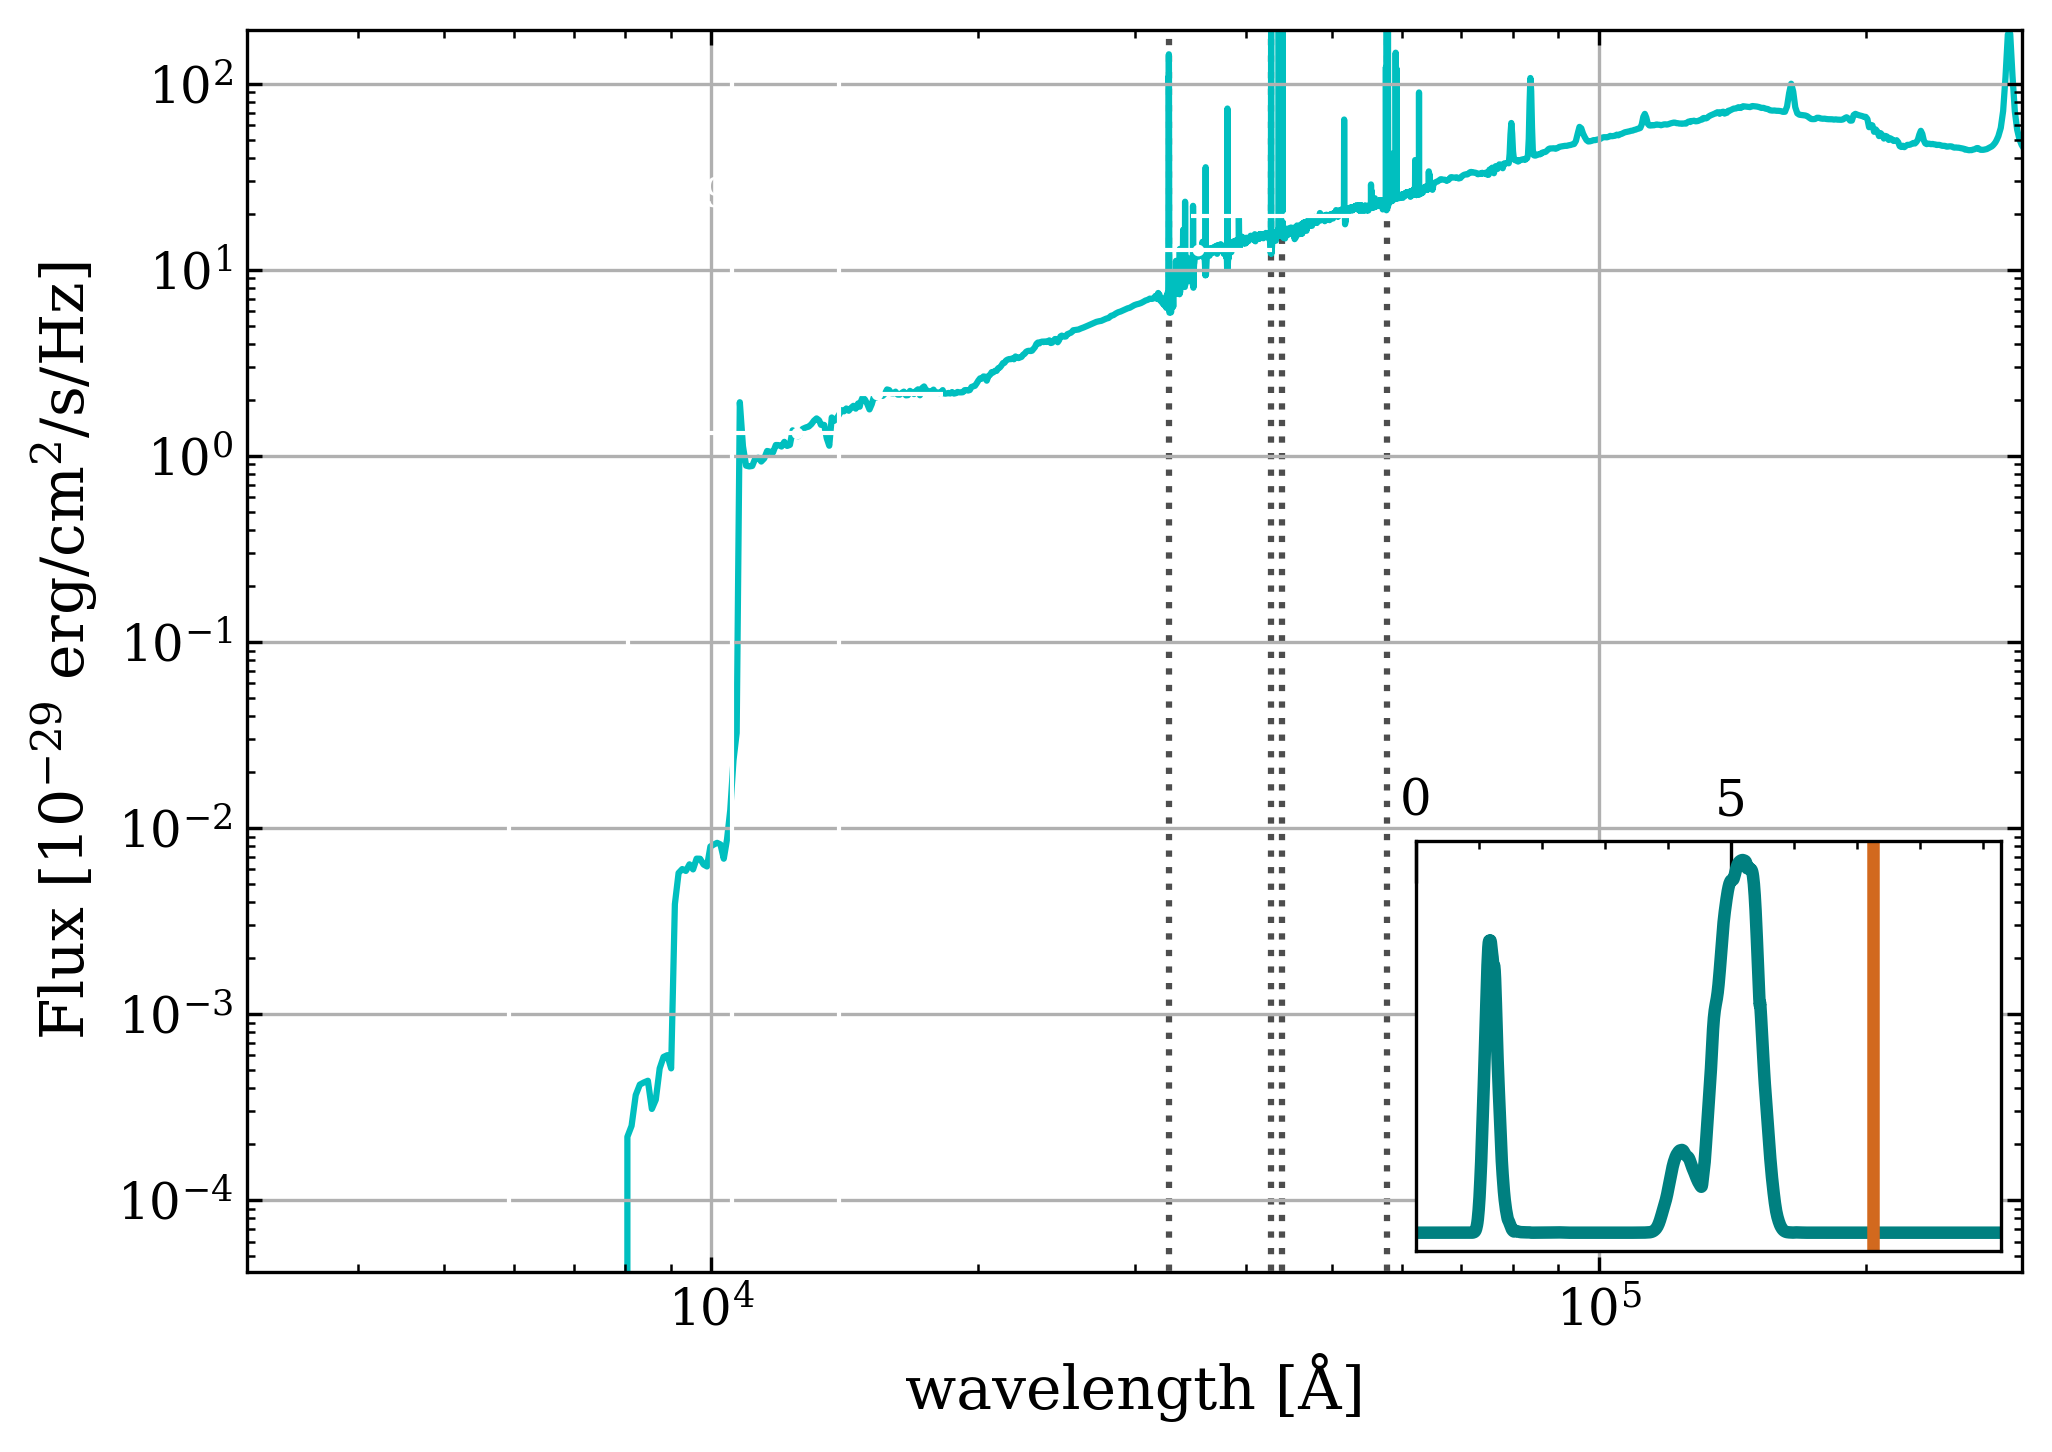

In [44]:
### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.w', ecolor = 'w', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3000,300000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# annotate
ax.annotate(text='photo-z='+str(za),xy=(0.15,0.83),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='spec-z='+str(zguess),xy=(0.15,0.8),xycoords='figure fraction',fontsize='small',color='w')
#ax.annotate(text='MUV='+str(np.round(MUV[0],2)),xy=(0.15,0.77),xycoords='figure fraction',fontsize='small',color='w')
#ax.annotate(text='J mag='+str(np.round(Jmag[0],2)),xy=(0.15,0.74),xycoords='figure fraction',fontsize='small',color='w')


# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='lower right')
zarr = np.linspace(0,10,num=len(zpdf[1:]))
axin.plot(zarr,zpdf[1:],c='teal',lw=3,label=r'$z_{phot}=$'+str(za))
axin.axvline(zguess,c='chocolate',lw=3,label=r'$z_{Ly-\alpha}=$'+str(zguess))
xmin = [za-1.5 if (za > 1.5)==True else 0][0]
axin.set_xlim(0,za+1.5)
axin.xaxis.tick_top()
axin.tick_params(size=10)
axin.yaxis.set_ticks([])
axin.xaxis.set_label_position('top') 
axin.grid(False)

In [371]:
idx

array([], dtype=int64)

In [8]:
wvl = idl.photz[0].templates[0].lam_rest[0]*u.AA
fnu_mod = idl.photz[0].templates[0].model[0][ind]*u.erg/u.s/u.Hz/u.cm**2

In [24]:
fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

<ErrorbarContainer object of 3 artists>

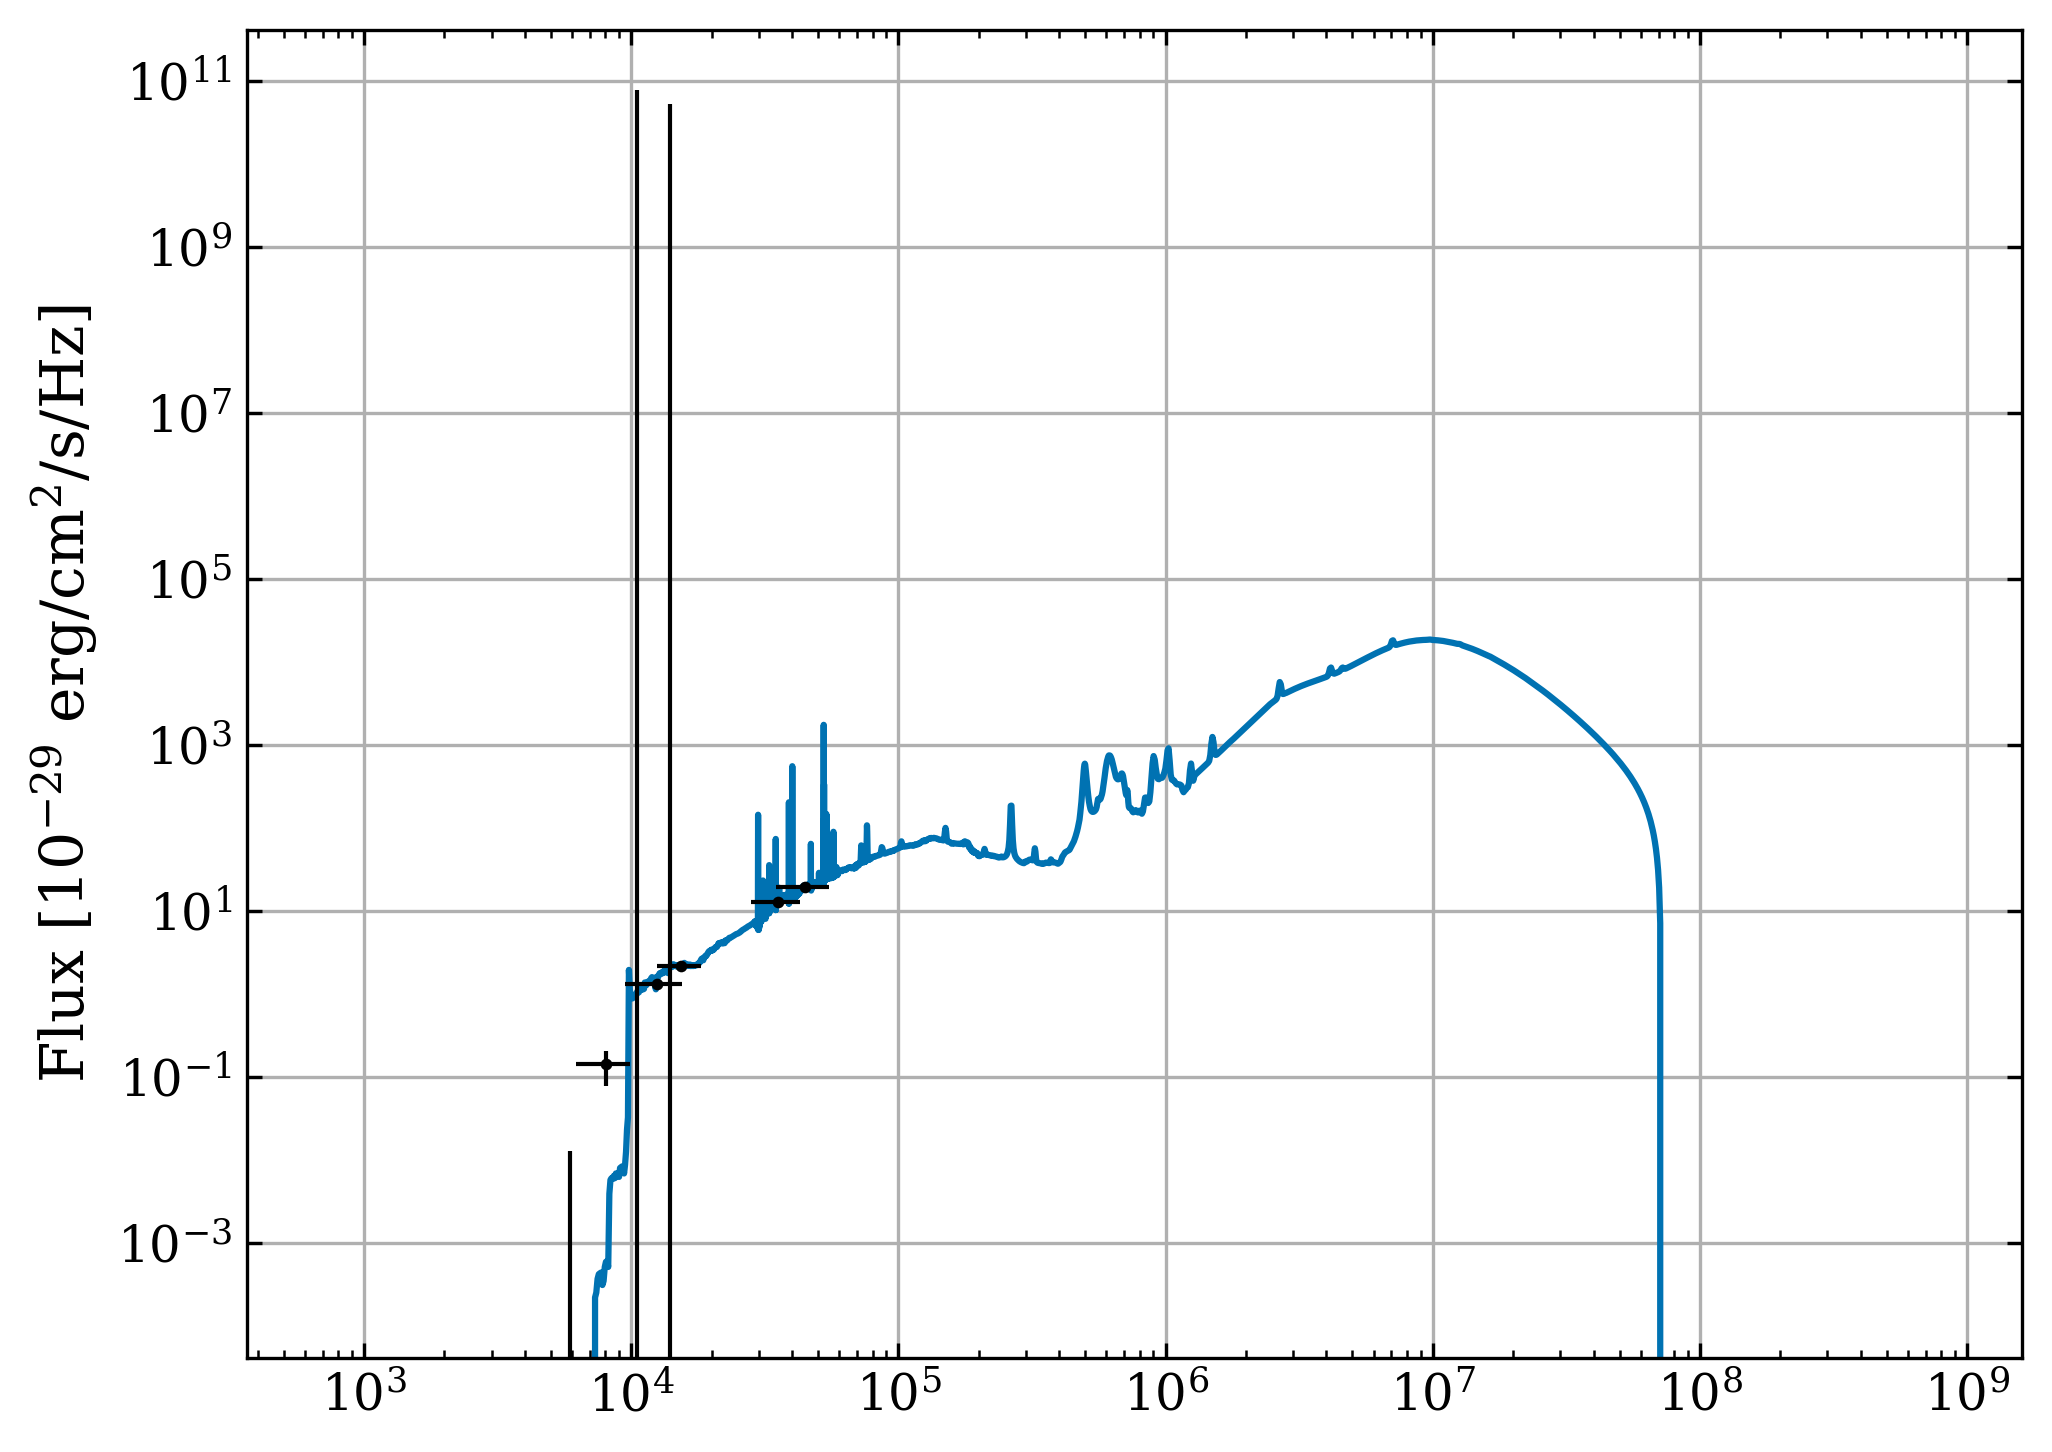

In [25]:
fig, ax = plt.subplots(1, figsize=[7,5])
plt.yscale('log')
plt.xscale('log')

#plt.xlim(0,8)
ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.plot(wvl*8,fnu_mod*1e29)
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)

In [29]:
ymin = np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5
ymax = np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*6
ymin,ymax

(<Quantity -0.01611655 erg / (cm2 Hz s)>,
 <Quantity 116.79428501 erg / (cm2 Hz s)>)

In [74]:
from astropy.cosmology import Planck15 as cosmo

# find UV mag
Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
MUV = (Jmag.value)-(cosmo.distmod(zguess).value)+(2.5*np.log10(1+zguess)) # abs UV mag
MUV

-20.69900471941478

In [72]:
(2.5*np.log10(1+zguess))

2.4088793339352406

In [78]:
Table.read('/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22.fits')

ID [66783],RA [66783],DEC [66783],CANDELS_RA [66783],CANDELS_DEC [66783],F606W [66783],F814W [66783],F105W [66783],F125W [66783],F140W [66783],F160W [66783],F36 [66783],F45 [66783],DF606W [66783],DF814W [66783],DF105W [66783],DF125W [66783],DF140W [66783],DF160W [66783],DF36 [66783],DF45 [66783],ZA [66783],ZL68 [66783],ZU68 [66783],ZPEAK [66783],ZA_NOIRAC [66783],ZL68_NOIRAC [66783],ZU68_NOIRAC [66783],ZPEAK_NOIRAC [66783]
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1 .. 70993,215.203681 .. 214.877608,52.954234 .. 52.882135,215.20362854003906 .. 214.87765502929688,52.954280853271484 .. 52.88215255737305,1.5235348804338691e-06 .. 12.382918746990757,3.369499365788353 .. 13.28607057181451,1.9236970122032417e-40 .. 2.887596772798109e-17,11.52469982950453 .. 20.471424737792216,0.0 .. 4.34379991122186,133.22484454982862 .. 31.22904468868794,0.0 .. -159.11810495524674,0.0 .. -36.98978436582107,11231114792581.338 .. 5.425009875078977,23.16010761672432 .. 6.203939227018612,14717819824690.346 .. 8855776772434.8,18.52857612489946 .. 10.860118036682724,11533327807650.072 .. 15.664349057450965,24.178846875580973 .. 8.85756457043262,2400000000000.0 .. 122.55532833258972,2400000000000.0 .. 127.32806748181052,10.239999999999826 .. 2.3599999999999937,3.0299999999999794 .. 0.6200000000000003,11.96999999999979 .. 3.3599999999999723,7.693721401715042 .. 2.092821641457744,10.239999999999826 .. 2.3599999999999937,3.2599999999999745 .. 0.8800000000000006,13.249999999999762 .. 4.069999999999958,11.323346550484358 .. 2.5262528532968416


In [130]:
obj_name = 'NSFin_EGS_SF_z7_29314'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
wra = float(notes['objra'][idx]); wdec = float(notes['objdec'][idx])
print('working on object',obj_name,'with zguess = ',zguess)

working on object NSFin_EGS_SF_z7_29314 with zguess =  7.34


In [9]:
file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_trimmed.idl'
pzfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_pz.idl'
ezfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_EAZYSED.idl'
pz = scipy.io.readsav(pzfile)
ez = scipy.io.readsav(ezfile)
idl = scipy.io.readsav(file).cat
# load best fit sed
wvl_rest = ez.lam_rest*u.AA
fnu_mods = ez.model*u.erg/u.s/u.Hz/u.cm**2

/opt/anaconda3/lib/python3.9/site-packages/scipy/io/idl.py:465: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


In [8]:
ez

{'lam_rest': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'za': array([10.18,  5.4 ,  4.28, ...,  1.17,  1.14,  2.3 ]),
 'model': array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.15073668e-031, 3.15201292e-031, 4.47760100e-118],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.33737381e-030, 1.33850092e-030, 6.17461536e-083],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.37983839e-031, 3.38253866e-031, 1.73106885e-081],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.38978808e-031, 3.39346532e-031, 2.69400778e-089],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.17687088e-031, 2.17921421e-031, 9.74386725e-109],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         8.55856415e-032, 8.56734495e-032, 5.35416074e-086]])}

(1e-31, 1e-27)

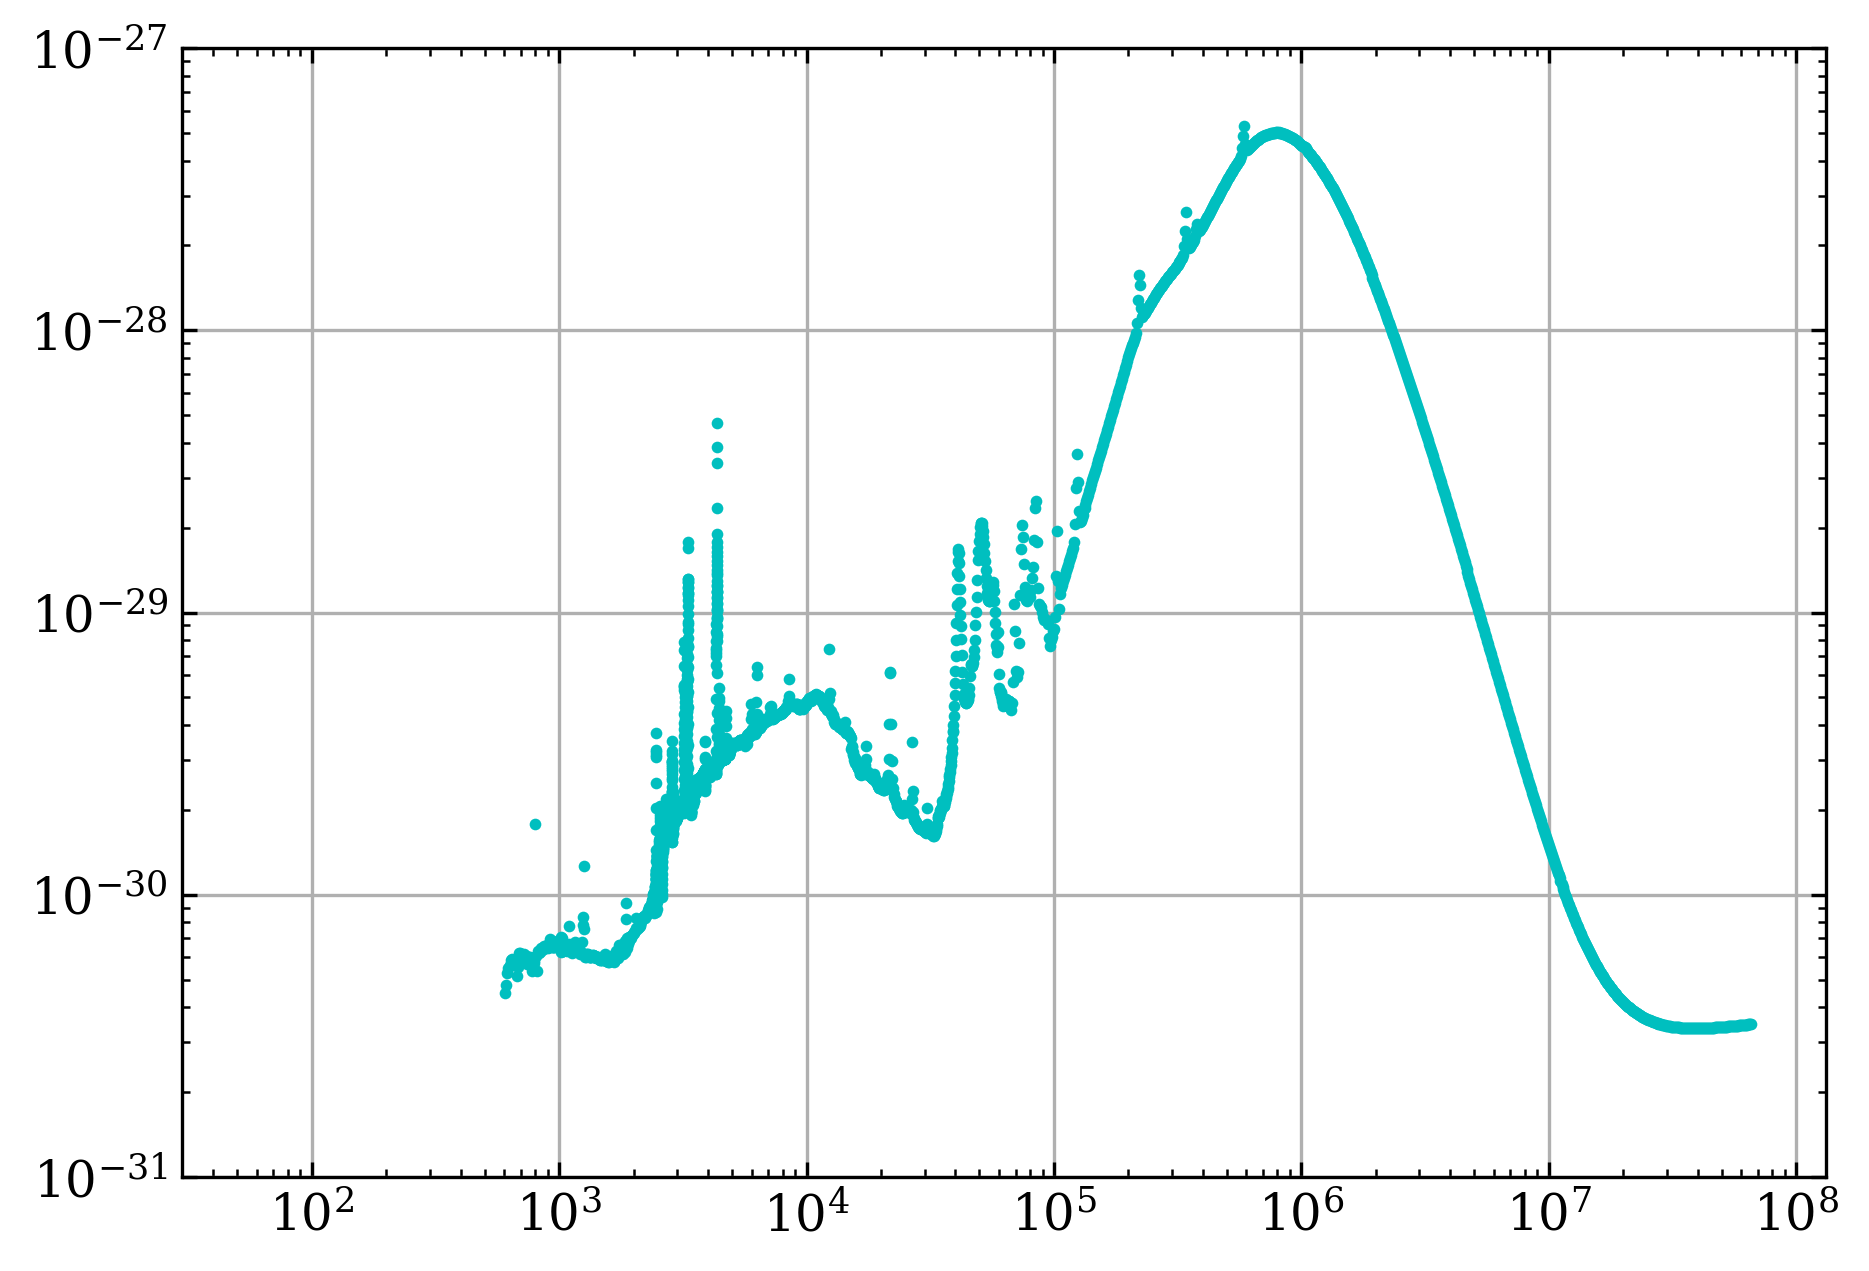

In [11]:
import scipy.io
from matplotlib import pyplot as plt 

ezfile = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_EAZYSED.idl'
ez = scipy.io.readsav(ezfile)

# load best fit sed
wvl = ez.lam_rest # *u.AA
fnu_mods = ez.model # *u.erg/u.s/u.Hz/u.cm**2

plt.plot(wvl*ez.za[100],ez.model[100],'c.')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-31,1e-27)

In [132]:
# load catalog ra/dec
catra = idl.ra[0]; catdec = idl.dec[0]
# crossmatch
c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
ind, d2d, d3d = catalog.match_to_catalog_sky(c)
if d2d > 1*u.arcsec:
    print("!! xmatch to source is > 1 arcsec !!")

print('distance to xmatch is ',d2d.to(u.arcsec))

# load fluxes
fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

# find mags
Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
MUV = (Jmag.value)-(cosmo.distmod(zguess).value)+(2.5*np.log10(1+zguess)) # abs UV mag

distance to xmatch is  [0.0364514arcsec]


In [133]:
# load best fit sed
fnu_mod = fnu_mods[ind]

# load zpdf
za = idl.photz[0].za[0][ind]
zarr = pz.zgrid
zpdf = pz.pz[ind]

/var/folders/d6/g8pl6rhs3jl3bg4kr5sfjgysmsx2tc/T/ipykernel_23263/2261690005.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ymin,ymax)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


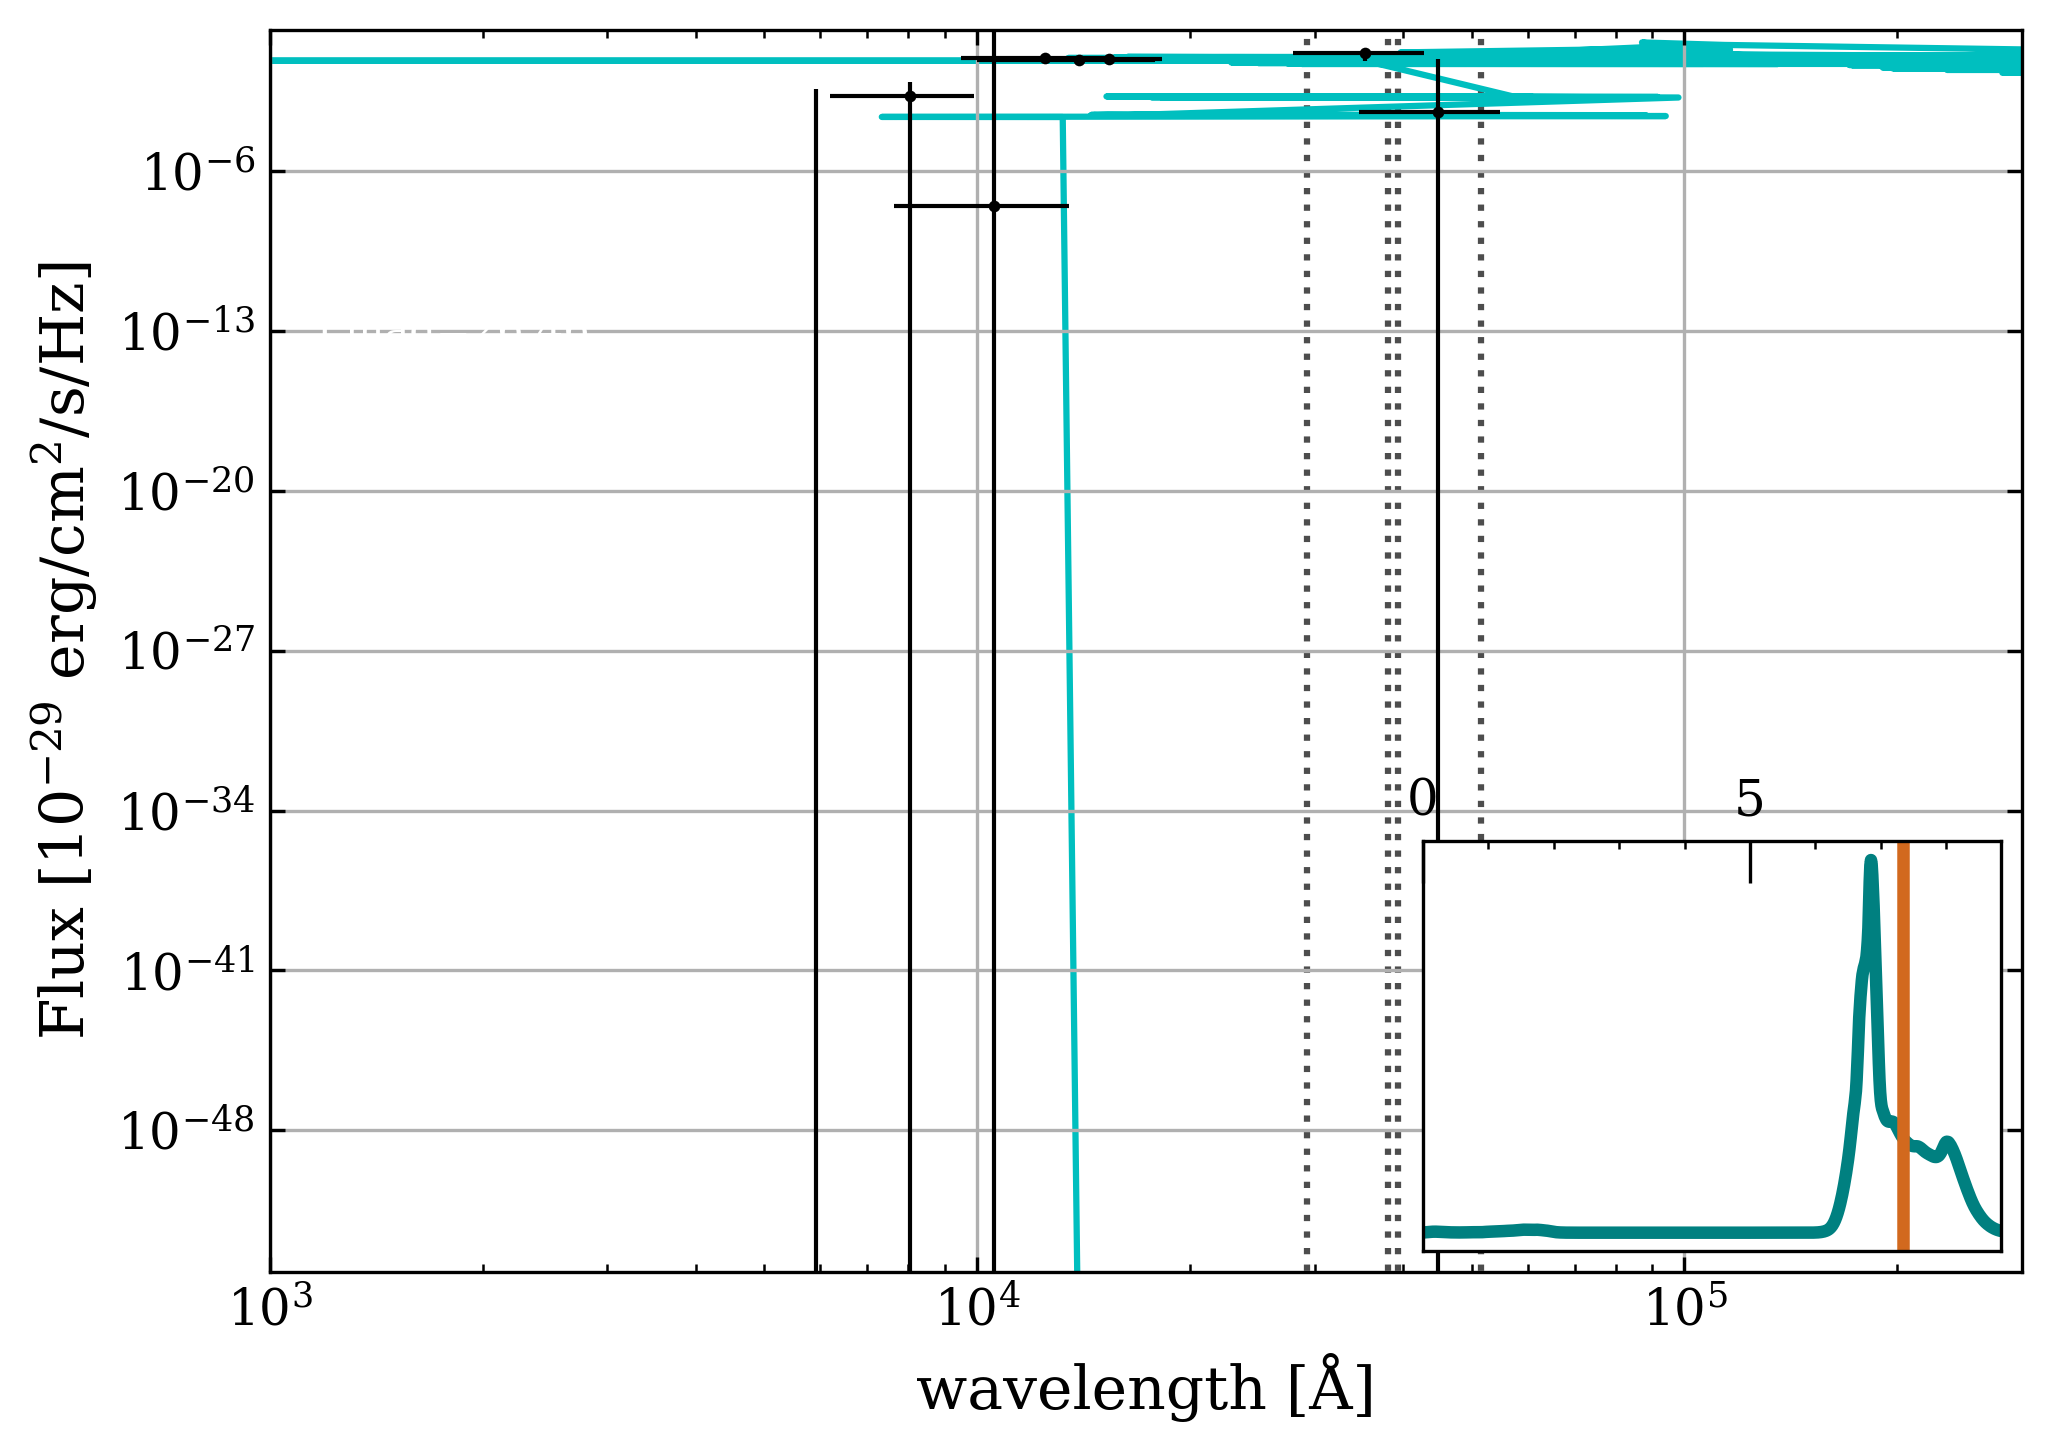

In [134]:
### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,300000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# annotate
ax.annotate(text='photo-z='+str(np.round(za,2)),xy=(0.15,0.83),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='spec-z='+str(zguess),xy=(0.15,0.8),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='MUV='+str(np.round(MUV,2)),xy=(0.15,0.77),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='J mag='+str(np.round(Jmag.value,2)),xy=(0.15,0.74),xycoords='figure fraction',fontsize='small',color='w')


# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='lower right')
axin.plot(zarr,zpdf,c='teal',lw=3)
axin.axvline(zguess,c='chocolate',lw=3)
xmin = [za-1.5 if (za > 1.5)==True else 0][0]
axin.set_xlim(0,zguess+1.5)
axin.xaxis.tick_top()
axin.tick_params(size=10)
axin.yaxis.set_ticks([])
axin.xaxis.set_label_position('top') 
axin.grid(False)


In [150]:
ez.model

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.15073668e-031, 3.15201292e-031, 4.47760100e-118],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.33737381e-030, 1.33850092e-030, 6.17461536e-083],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.37983839e-031, 3.38253866e-031, 1.73106885e-081],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.38978808e-031, 3.39346532e-031, 2.69400778e-089],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.17687088e-031, 2.17921421e-031, 9.74386725e-109],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        8.55856415e-032, 8.56734495e-032, 5.35416074e-086]])

(1e-34, 1e-27)

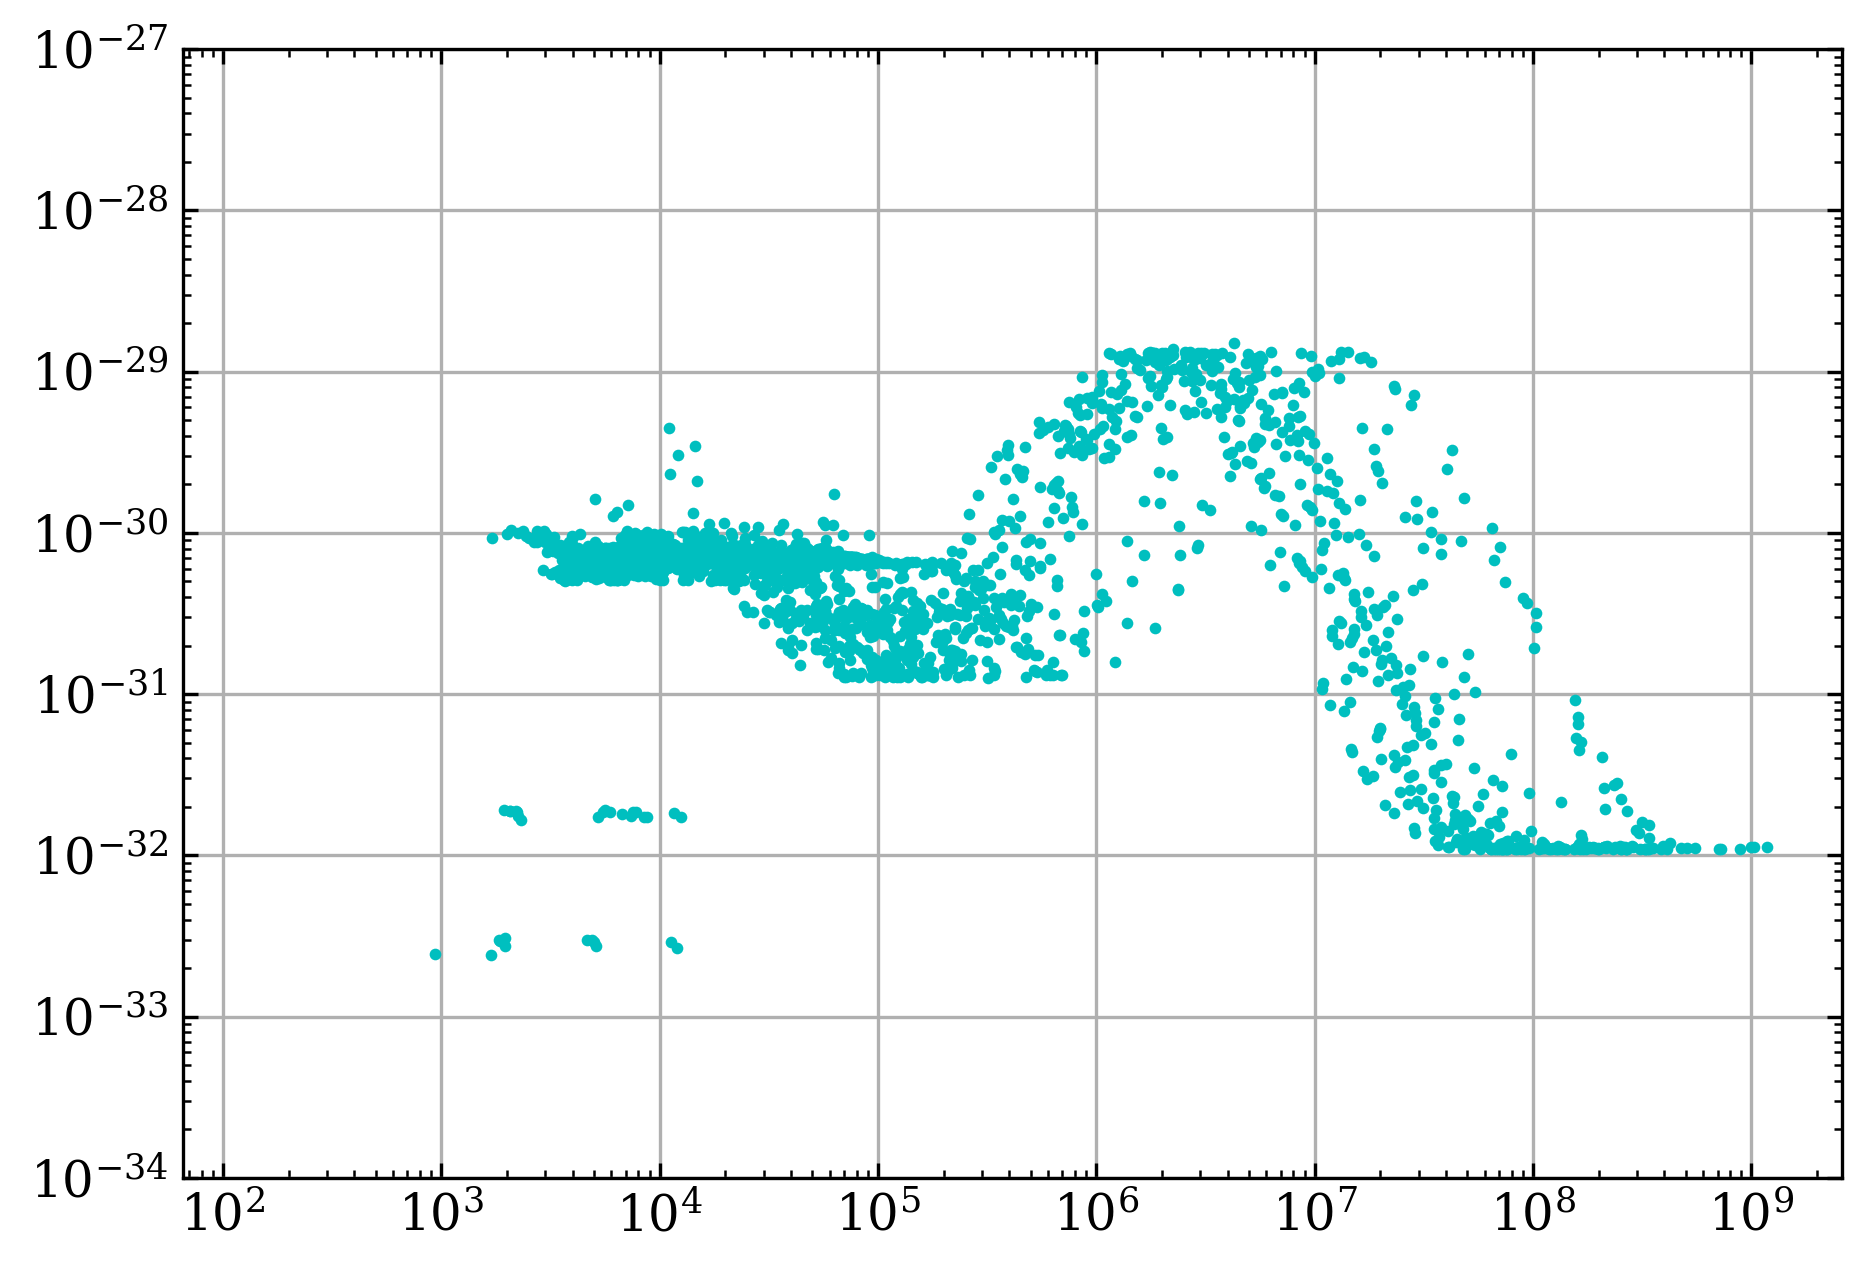

In [146]:
plt.plot(ez.lam,ez.model[ind],'c.')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-34,1e-27)

In [87]:
# load fluxes
fnu_obs = [idl.flux[0][0][i][ind] for i in range(len(idl.flux[0][0]))]*u.nJy
fnu_obserr = [idl.dflux[0][0][i][ind] for i in range(len(idl.dflux[0][0]))]*u.nJy
filt_name = idl.flux[0].dtype.names
filt_lambda = [.592188,.804553,1.055025,1.248607,1.392321,1.537034,3.537841,4.478049]*u.um
filt_fwhm = [.232293,.185835,.291703,.300520,.394088,.287418,.743171,1.009682]*u.um

# find mags
Jmag = (idl.flux[0].FJ[0][ind]*u.nJy).to(u.ABmag) # apparent J mag
MUV = (Jmag.value)-(cosmo.distmod(zguess).value)+(2.5*np.log10(1+zguess)) # abs UV mag

# load best fit sed
fnu_mod = fnu_mods[ind]

NameError: name 'fnu_mods' is not defined

In [ ]:


# load zpdf
za = idl.photz[0].za[0][ind]
zarr = idl.photz[0].zgrid[0]
zpdf = idl.photz[0].pz[0][ind]



### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])

ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
ax.errorbar(filt_lambda.to(u.AA),fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,xerr=filt_fwhm.to(u.AA),yerr=fnu_obserr.to(u.erg/u.s/u.Hz/u.cm**2)*1e29,fmt='.w', ecolor = 'w', capsize=3, elinewidth=1,zorder=2)
ymin = (np.min(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*0.5).value
ymax = (np.max(fnu_obs.to(u.erg/u.s/u.Hz/u.cm**2))*1e29*10).value


# Plot the best-fit model 
ax.plot(wvl*(1+za),fnu_mod*1e29,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+za),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+za),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+za),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+za),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,300000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# annotate
ax.annotate(text='photo-z='+str(np.round(za,2)),xy=(0.15,0.83),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='spec-z='+str(zguess),xy=(0.15,0.8),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='MUV='+str(np.round(MUV,2)),xy=(0.15,0.77),xycoords='figure fraction',fontsize='small',color='w')
ax.annotate(text='J mag='+str(np.round(Jmag.value,2)),xy=(0.15,0.74),xycoords='figure fraction',fontsize='small',color='w')


# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='lower right')
axin.plot(zarr,zpdf,c='teal',lw=3)
axin.axvline(zguess,c='chocolate',lw=3)
xmin = [za-1.5 if (za > 1.5)==True else 0][0]
axin.set_xlim(0,zguess+1.5)
axin.xaxis.tick_top()
axin.tick_params(size=10)
axin.yaxis.set_ticks([])
axin.xaxis.set_label_position('top') 
axin.grid(False)

In [128]:
clr = Table.read('COSMOS_lristargets_2022A.txt',format='ascii')
ulr = Table.read('UDS_WERLS_LRIS_targets_2022A.txt',format='ascii')
elr = Table.read('werls_egs_2022A_lris_targets.txt',format='ascii')
elr['jmag'].name = 'mag'; elr['lris_mask_name'].name = 'maskname'

In [131]:
lris = astropy.table.vstack([clr,ulr,elr])

In [134]:
nn = notes[(notes['obj'] != None) == True]
nn['obj'].name = 'name'

In [136]:
xclr = astropy.table.join(lris,nn,keys='name',join_type='inner')

In [139]:
xclr.write('lris_mosfire_overlap_2022.txt',format='ascii')

In [81]:
# select object
notesfull = Table.read('cooper_full_notes.csv',format='csv')
notes = notesfull[notesfull['photoz_source']=='cand']
notes

mask,slit_no,obj,c2020_id,ypix_mospy,mospy_notes,pypeit_notes,wp,mia,keep,confidence,cquality,zguess,zmeasured,wave,ypix_slit,photoz,photoz_source,MUV,serendip_ra,serendip_dec,pypeit_ref_idx,pypeit_slit,pypeit_name,maskdef_id,objra,objdec,spat_pixpos,spat_fracpos,box_width,opt_fwhm,s2n,maskdef_extract
str6,int64,str26,int64,int64,str42,str54,int64,int64,int64,int64,float64,str6,float64,int64,str2,int64,str5,int64,str9,str7,int64,int64,str23,int64,float64,float64,float64,float64,int64,float64,float64,str5
wmmc01,11,CAND_M8502,--,1581,"l@9871?,l@10031?LOWZ","nl,nc",1,--,--,-1,1.0,7.25,7.2514,10031,23,--,cand,--,--,--,23,1060,SPAT1061-SLIT1060-DET01,11,150.17275,2.20622,1061.0,0.536,1,0.3,0.13,True
wmmc01,14,CAND_L4510,--,--,"nl,nc","nl,nc",1,--,--,0,-1.0,--,--,--,--,--,cand,--,--,--,20,913,SPAT0916-SLIT0913-DET01,14,150.1585,2.18811,916.0,0.56,1,0.3,-0.02,True
wmmc01,18,CAND_M5825,--,1041,"l@9916?onsky,l@11098?11103?doublet?","nl,nc",1,--,--,1,0.0,8.12,8.133,11103,19,--,cand,--,--,--,16,706,SPAT0705-SLIT0706-DET01,18,150.14462,2.19378,705.0,0.464,1,0.3,0.08,True
wmmc01,20,CAND_L8232,--,--,l@10885?onstar,"nl,nc",1,--,--,1,1.0,7.96,7.955,10885,41,--,cand,--,--,--,14,596,SPAT0601-SLIT0596-DET01,20,150.13979,2.20466,601.0,0.588,1,0.3,0.23,True
wmmc01,22,CAND_M9262,--,686,cmc:l@9995?,"nl,nc",1,--,--,0,0.0,7.22,7.2218,9995,25,--,cand,--,--,--,11,476,SPAT0471-SLIT0476-DET01,22,150.13075,2.20911,471.0,0.4,1,0.3,-0.03,True
wmmc01,28,CAND_L4631,--,278,l@10141?,"nl,nc",1,--,--,1,1.0,7.34,7.341,10140,28,--,cand,--,--,--,5,196,SPAT0197-SLIT0196-DET01,28,150.10725,2.1887,197.0,0.556,1,0.3,-0.08,True
wmmc01,29,CAND_L9078,--,228,l@9802?onsky,"l@[156,38]?",1,--,--,0,-1.0,-1,--,9802,--,--,cand,--,--,--,4,158,SPAT0159-SLIT0158-DET01,29,150.10946,2.20816,159.0,0.536,1,0.3,-0.27,True
wmmc01,30,CAND_L7135,--,--,"nl,nc","nl,nc",1,--,--,0,-1.0,--,--,--,--,--,cand,--,--,--,3,110,SPAT0103-SLIT0110-DET01,30,150.10321,2.19955,103.0,0.367,1,0.3,0.09,True
wmmc01,31,CAND_B4151,--,82,"l@10513?onsky,l@9803?,l@10700?INCONSISTENT","l@[65,951]?",1,--,--,0,-1.0,-1,--,10272,25,--,cand,--,--,--,2,62,SPAT0064-SLIT0062-DET01,31,150.09754,2.18601,64.0,0.593,1,0.3,-0.05,True


In [82]:
photz = []
for idx in range(len(notes['obj'])):
    wra = float(notes['objra'][idx]); wdec = float(notes['objdec'][idx])
    print('working on object',notes['obj'][idx])

    if notes['mask'][idx][:-2] == 'wmmc':
        print('wmmc')
        file = '/Users/oc4858/werls/COSMOS_F21.idl'
        idl = scipy.io.readsav(file).cat
    elif notes['mask'][idx][:-2] == 'wmmu':
        print('wmmu')
        file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/uds/UDS_candidates_all.idl'
        idl = scipy.io.readsav(file).fobj
    elif notes['mask'][idx][:-2] == 'wmme':
        print('wmme')
        file = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/egs/EGS_F22_trimmed.idl'
        idl = scipy.io.readsav(file).cat
        
    # load catalog ra/dec
    catra = idl.ra[0]; catdec = idl.dec[0]
    # crossmatch
    c = SkyCoord(ra=catra*u.degree, dec=catdec*u.degree)
    catalog = SkyCoord(ra=wra*u.degree, dec=wdec*u.degree)
    ind, d2d, d3d = catalog.match_to_catalog_sky(c)
    if d2d > 1*u.arcsec:
        print("!! xmatch to source is > 1 arcsec !!")

    print('distance to xmatch is ',d2d.to(u.arcsec))
    # load photz
    za = idl.photz[0].za[0][ind]
        
    print(za)
    photz.append(za)
    print(' ')

working on object CAND_M8502
wmmc
distance to xmatch is  [0.0407143arcsec]
7.789999999999878
 
working on object CAND_L4510
wmmc
distance to xmatch is  [0.0458038arcsec]
5.179999999999934
 
working on object CAND_M5825
wmmc
distance to xmatch is  [0.10239arcsec]
7.189999999999891
 
working on object CAND_L8232
wmmc
distance to xmatch is  [0.0367119arcsec]
0.8800000000000006
 
working on object CAND_M9262
wmmc
distance to xmatch is  [0.0382562arcsec]
8.099999999999872
 
working on object CAND_L4631
wmmc
distance to xmatch is  [0.0382527arcsec]
4.679999999999945
 
working on object CAND_L9078
wmmc
distance to xmatch is  [0.0621009arcsec]
5.289999999999932
 
working on object CAND_L7135
wmmc
distance to xmatch is  [0.035983arcsec]
5.329999999999931
 
working on object CAND_B4151
wmmc
distance to xmatch is  [0.0179953arcsec]
7.569999999999883
 
working on object CAND_L24736
wmmc
distance to xmatch is  [0.0978596arcsec]
5.279999999999932
 
working on object CAND_M23930
wmmc
distance to xmat

!! xmatch to source is > 1 arcsec !!
distance to xmatch is  [6.20478arcsec]
5.419999999999929
 
working on object rybou_UDSZ-0806014558
wmmu
distance to xmatch is  [0.283958arcsec]
0.01
 
working on object L_WPCAND26050
wmmu
distance to xmatch is  [0.195591arcsec]
5.049999999999937
 
working on object upz_32517_1.72_26.9
wmmu
!! xmatch to source is > 1 arcsec !!
distance to xmatch is  [21.3395arcsec]
5.049999999999937
 
working on object B_WPCAND-29712
wmmu
distance to xmatch is  [0.17773arcsec]
6.689999999999902
 
working on object upz_14604_1.65_24.7
wmmu
!! xmatch to source is > 1 arcsec !!
distance to xmatch is  [14.4904arcsec]
4.679999999999945
 
working on object L_WPCAND30044
wmmu
distance to xmatch is  [0.210584arcsec]
5.339999999999931
 
working on object M_WPCAND28264
wmmu
distance to xmatch is  [0.221958arcsec]
6.979999999999896
 
working on object B_WPCAND-26169
wmmu
distance to xmatch is  [0.196266arcsec]
6.669999999999902
 
working on object L_WPCAND-26936
wmmu
distance t

distance to xmatch is  [0.0130241arcsec]
4.259999999999954
 
working on object NSFil_19401
wmme
distance to xmatch is  [0.0322586arcsec]
1.2000000000000008
 
working on object B_W34153
wmme
distance to xmatch is  [0.0322629arcsec]
7.039999999999894
 
working on object NSFil_26556
wmme
distance to xmatch is  [0.219611arcsec]
1.1600000000000008
 
working on object NSFil_39162
wmme
distance to xmatch is  [0.0264113arcsec]
4.849999999999941
 
working on object NSFil_23950
wmme
distance to xmatch is  [0.0242511arcsec]
1.2300000000000009
 
working on object NSFil_23332
wmme
distance to xmatch is  [0.0651386arcsec]
1.390000000000001
 
working on object NSFil_24405
wmme
distance to xmatch is  [0.0249478arcsec]
1.1800000000000008
 
working on object NSFil_21505
wmme
distance to xmatch is  [0.0300817arcsec]
1.430000000000001
 
working on object NSFil_37851
wmme
distance to xmatch is  [0.891781arcsec]
9.14999999999985
 
working on object NSNew_16149
wmme
distance to xmatch is  [0.0396595arcsec]
1

In [101]:
cpz = Table([notes['obj'],notes['mask'],photz,notes['zguess']],names=('obj','mask','candels_pz','zguess'))
cpz[98:]

obj,mask,candels_pz,zguess
str26,str6,float64,str6
NSFil_23198,wmme01,1.0900000000000007,1.11
B_W30645,wmme01,7.0799999999998935,--
NSKar_31009,wmme01,1.2000000000000008,--
B_W29881,wmme01,6.399999999999908,8.389
NSFil_16368,wmme01,1.420000000000001,1.644
M_W69492,wmme01,7.879999999999876,7.4775
B_W64853,wmme01,6.659999999999902,--
M_W35089,wmme01,7.579999999999883,--
NSFil_22209,wmme01,0.9100000000000006,--


In [102]:
ascii.write(cpz,'candels_pz.txt')

In [94]:
astropy.table.join(notesfull,cpz,keys='obj',join_type='left')

mask,slit_no,obj,c2020_id,ypix_mospy,mospy_notes,pypeit_notes,wp,mia,keep,confidence,cquality,zguess_1,zmeasured,wave,ypix_slit,photoz,photoz_source,MUV,serendip_ra,serendip_dec,pypeit_ref_idx,pypeit_slit,pypeit_name,maskdef_id,objra,objdec,spat_pixpos,spat_fracpos,box_width,opt_fwhm,s2n,maskdef_extract,candels_pz,zguess_2
str6,int64,str26,int64,int64,str42,str54,int64,int64,int64,int64,float64,str6,float64,int64,str2,int64,str5,int64,str9,str7,int64,int64,str23,int64,float64,float64,float64,float64,int64,float64,float64,str5,float64,str6
wmmc06,8,ALF_1159990,--,--,"bc,l@9993?",--,0,--,--,1,--,--,--,--,--,--,--,--,--,--,--,1178,SPAT1174-SLIT1178-DET01,8,150.07129,2.51905,1173.6,0.402,3,0.689,2.11,FALSE,--,--
wmme02,1,B_W10617,--,--,l@10791,--,1,--,--,1,-1.0,7.87,--,10791,--,--,cand,--,--,--,31,2672,SPAT2672-SLIT2672-DET01,1,214.92792,52.82428,2672.0,0.491,2,0.7,0.02,True,8.779999999999857,7.87
wmme01,27,B_W18092,--,--,"fc,l@11109","fc,l@354",1,--,--,1,-1.0,--,--,--,--,--,cand,--,--,--,8,602,SPAT0618-SLIT0602-DET01,27,215.06646,52.94187,618.0,0.66,2,0.7,0.04,True,6.699999999999902,--
wmme03,22,B_W22413,--,--,fc?,--,1,--,--,--,--,--,--,--,--,--,cand,--,--,--,--,880,SPAT0898-SLIT0880-DET01,22,214.87637,52.87766,898.0,0.684,2,1.0,0.18,True,5.889999999999919,--
wmme01,14,B_W25438,--,--,l@10903,l@189?,1,--,--,1,-1.0,7.96,--,10903,--,--,cand,--,--,--,21,1588,SPAT1580-SLIT1588-DET01,14,215.03512,52.98239,1580.0,0.414,2,0.7,0.0,True,6.629999999999903,7.96
wmme01,11,B_W25641,--,--,l@9774?,"nl,nc",1,--,--,0,-1.0,7.04,--,9774,--,--,cand,--,--,--,24,1807,SPAT1811-SLIT1807-DET01,11,215.044,52.98964,1811.0,0.571,2,0.7,0.02,True,7.399999999999887,7.04
wmme03,6,B_W27094,--,--,"diffuse,c,l@9930?checkalignment",--,1,--,--,1,0.0,--,--,--,--,--,cand,--,--,--,--,2200,SPAT2193-SLIT2200-DET01,6,214.94246,52.91473,2193.0,0.429,2,1.0,-0.23,True,6.929999999999897,--
wmme03,21,B_W27805,--,--,"nl,nc",--,1,--,--,0,-1.0,--,--,--,--,--,cand,--,--,--,--,987,SPAT0988-SLIT0987-DET01,21,214.89225,52.87743,988.0,0.51,2,1.0,0.05,True,8.68999999999986,--
wmme01,4,B_W29881,--,--,"nl,serendipfc",l@1778(11413),1,--,--,1,0.5,8.389,--,11413,--,--,cand,--,--,--,31,2465,SPAT2454-SLIT2465-DET01,4,215.0845,53.00869,2454.0,0.39,2,0.7,-0.01,True,6.399999999999908,8.389
